In [1]:
import pandas as pd
import numpy as np

from scipy import stats, odr

from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

# Reading Cleaned Data

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
# Data types
df.dtypes

Sex           object
Event         object
Age          float64
Tested        object
Squat        float64
Bench        float64
Dead         float64
Total        float64
Weight        object
AgeGroup    category
dtype: object

# Removing Non Drug Tested Competitions

Data Exploration and Statistical Testing will be first performed separately and the results will be compared at the end.


In [4]:
df = df[df['Tested']=='Yes'].reset_index(drop = True)

# Stratifying Strength Data

Total = Weight of all three lifts combined (must have three at one competition)

Deadlift = Weight of maximum deadlift

Bench Press = Weight of maximum bench press

Squat = Weight of maximum squat

In [5]:
total = df[(df['Event']=='SBD')&\
          (df['Total'].notnull())&(df['Total']>0)].reset_index(drop = True)[['Sex','Age','Tested','Total','Weight','AgeGroup']].copy()

dead = df[(df['Dead'].notnull())&\
         (df['Dead']>0)].reset_index(drop = True)[['Sex','Age','Tested','Dead','Weight','AgeGroup']].copy()

bench = df[(df['Bench'].notnull())&\
          (df['Bench']>0)].reset_index(drop = True)[['Sex','Age','Tested','Bench','Weight','AgeGroup']].copy()

squat = df[(df['Squat'].notnull())&\
          (df['Squat']>0)].reset_index(drop = True)[['Sex','Age','Tested','Squat','Weight','AgeGroup']].copy()

# Visualizations - Age, Weight, Strength

In [6]:
def quadrant(total,bench,squat,dead,sex,plot):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)
    
    if plot == 'Scatter':
        sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', color='steelblue', ax=axs[0, 0])
        sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()
    elif plot == 'Box':
        sns.boxplot(data=total[total['Sex'] == sex].copy(), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
        sns.boxplot(data=bench[bench['Sex'] == sex].copy(), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.boxplot(data=squat[squat['Sex'] == sex].copy(), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.boxplot(data=dead[dead['Sex'] == sex].copy(), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()

Sex = M

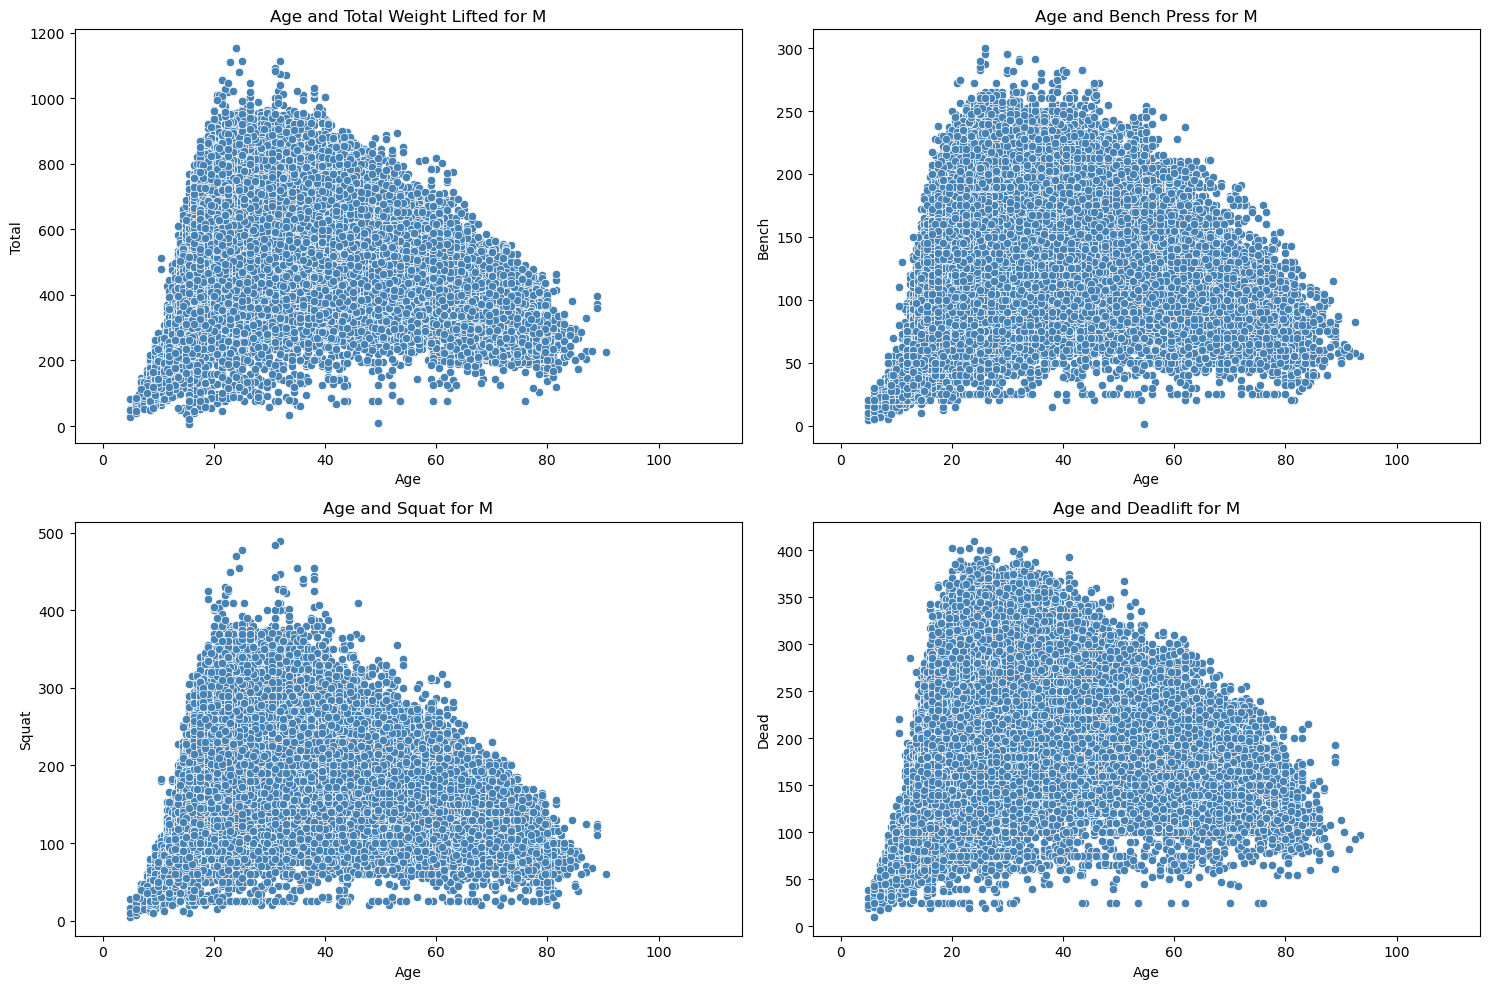

In [7]:
quadrant(total,bench,squat,dead,'M','Scatter')

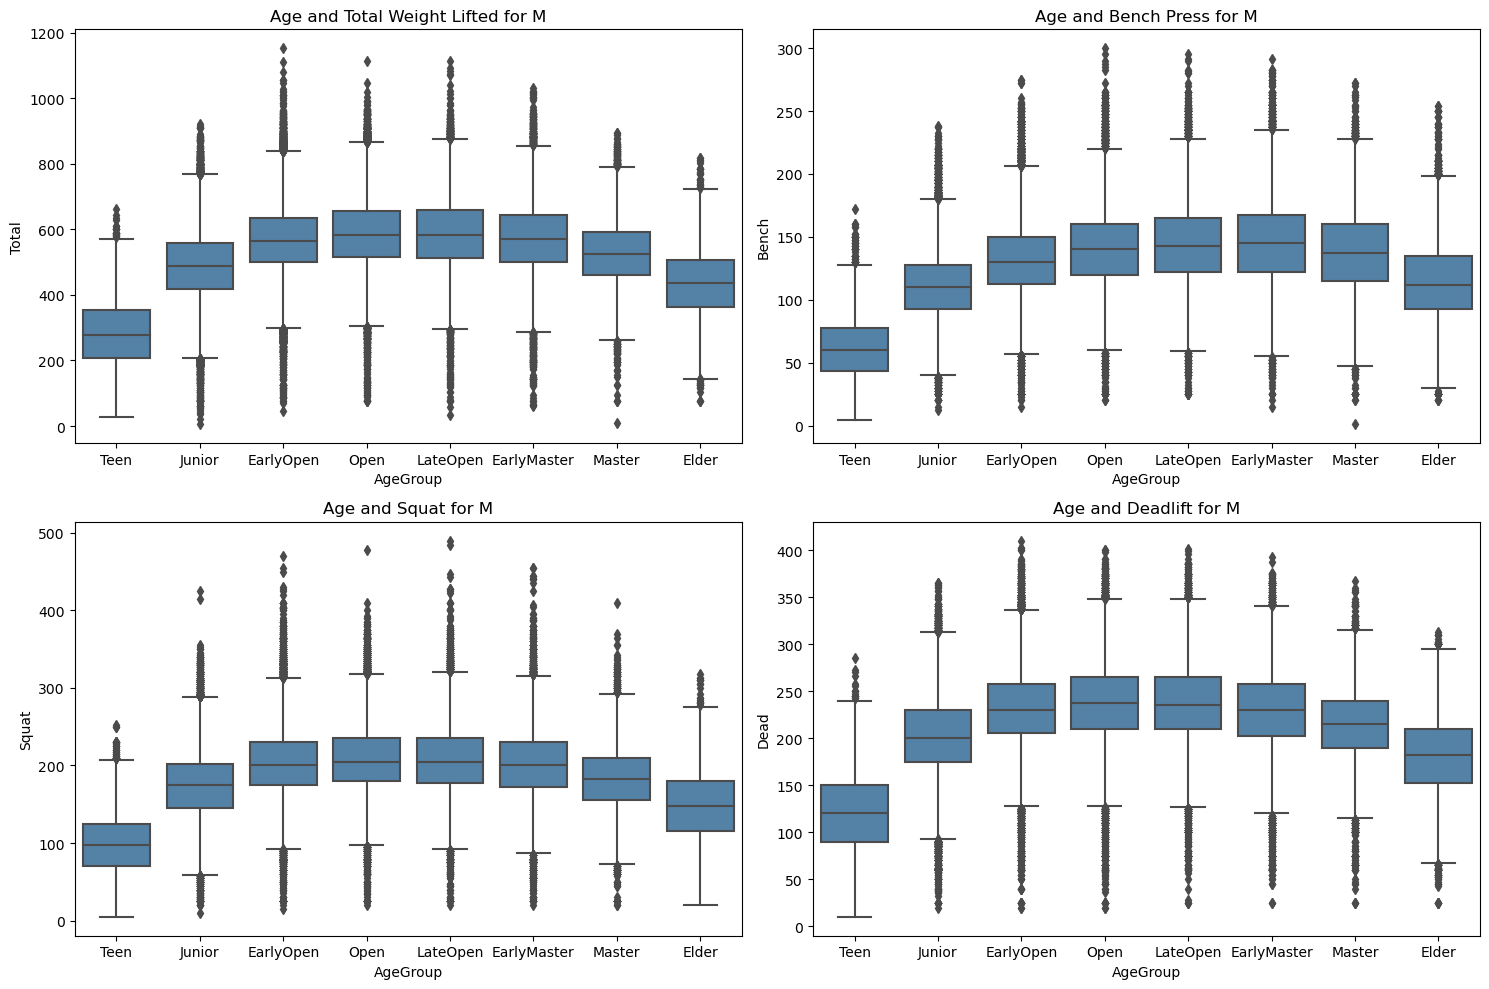

In [8]:
quadrant(total,bench,squat,dead,'M','Box')

Sex = F

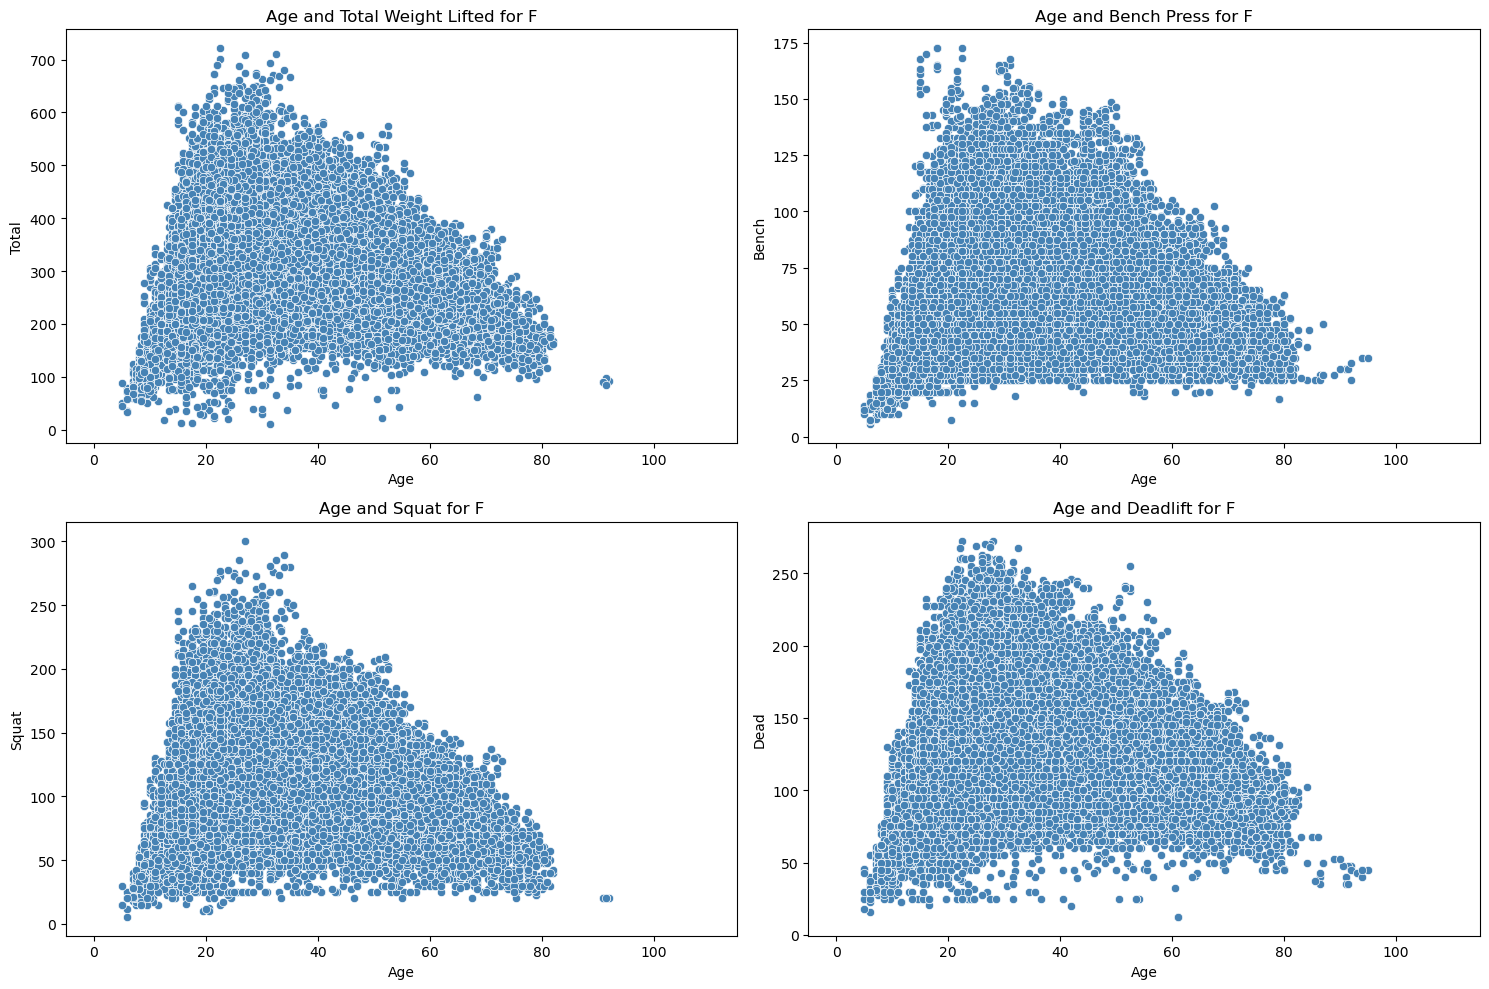

In [9]:
# Female
quadrant(total,bench,squat,dead,'F','Scatter')

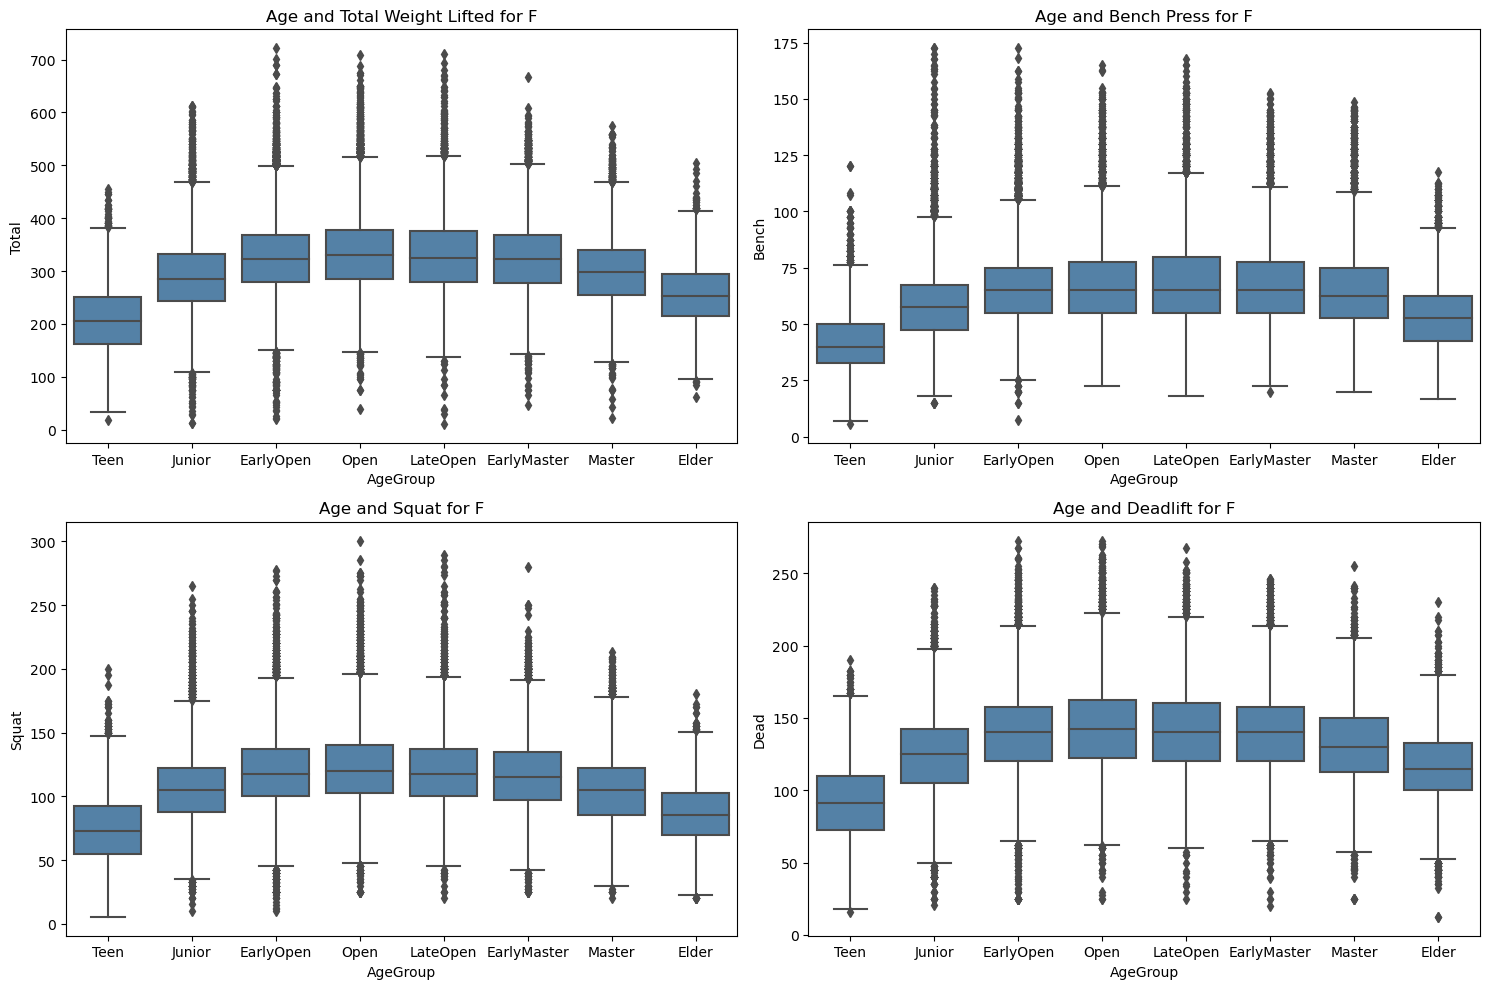

In [10]:
quadrant(total,bench,squat,dead,'F','Box')

Take a random sample for each age group

In [11]:
age_groups = df['AgeGroup'].unique()

def sample(total, n):
    dfs = pd.DataFrame()
    for x in range(len(age_groups)):
        a = total[total['AgeGroup']==age_groups[x]].copy()
        aa = a.sample(n = 500).copy()
        dfs = pd.concat([dfs,aa], axis = 0, ignore_index = True)
    return dfs

Sex = M

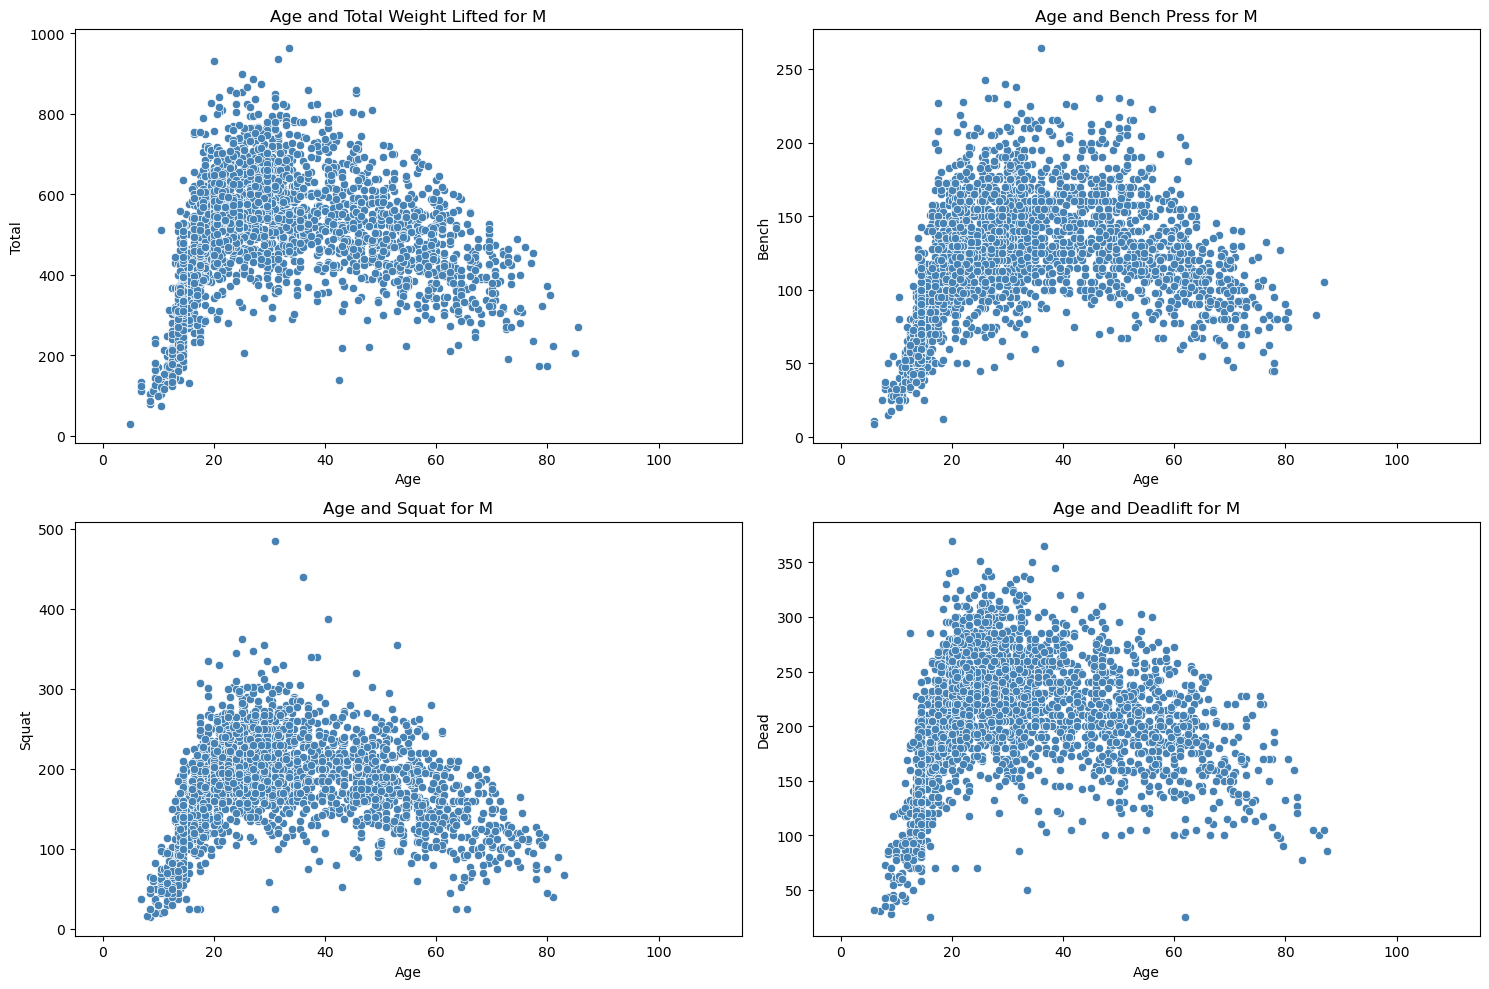

In [12]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Scatter')

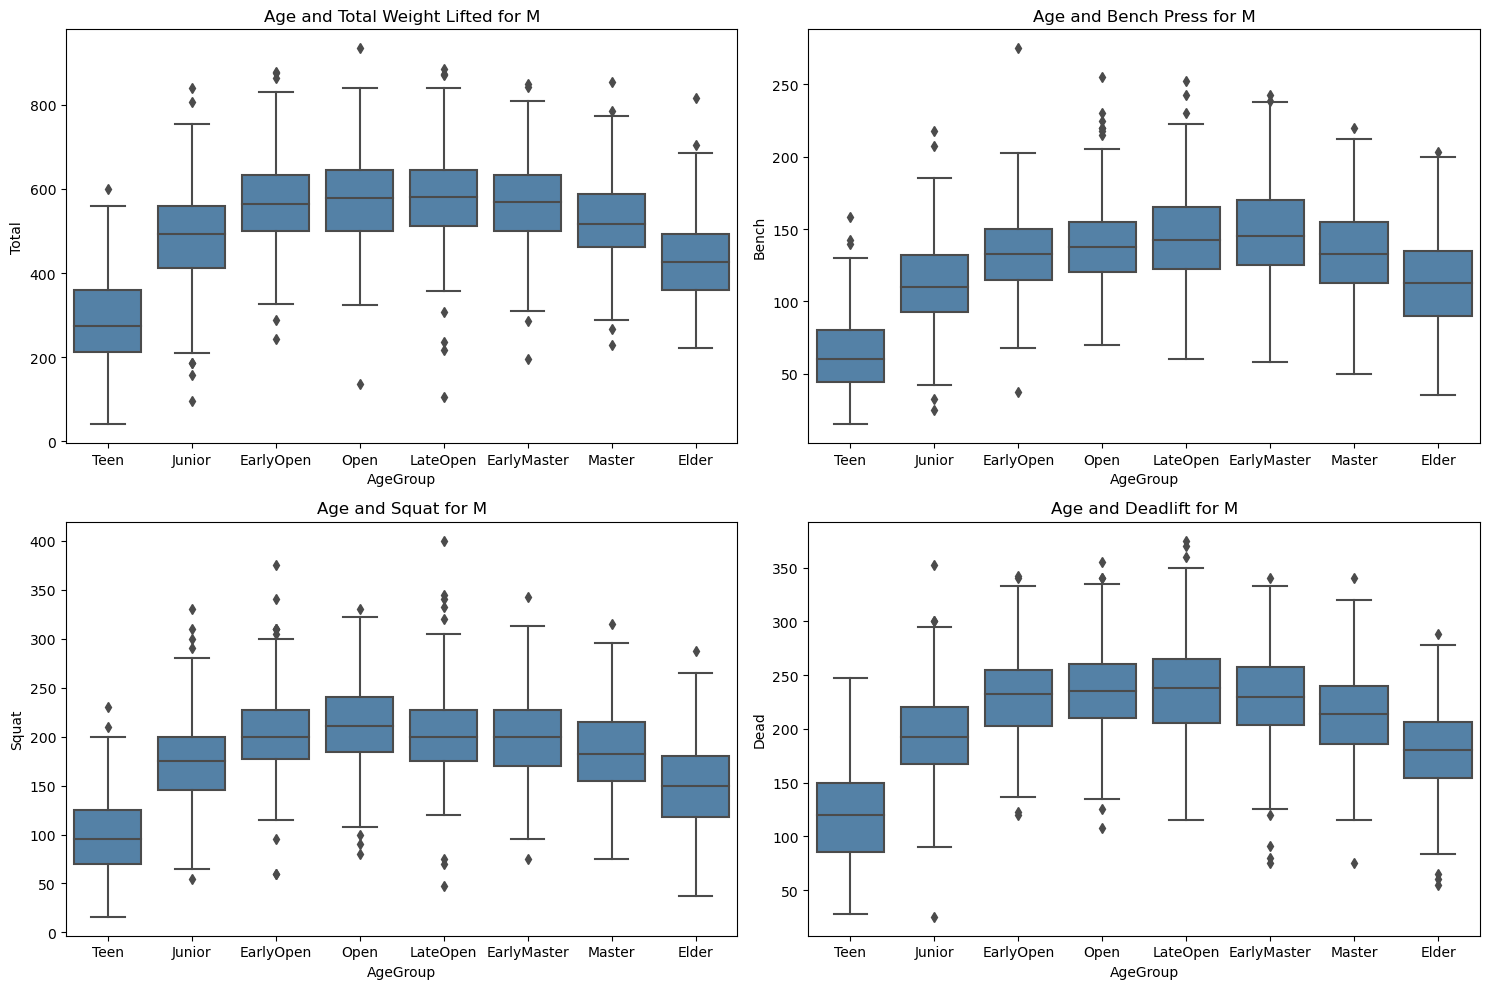

In [13]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Box')

Sex = F

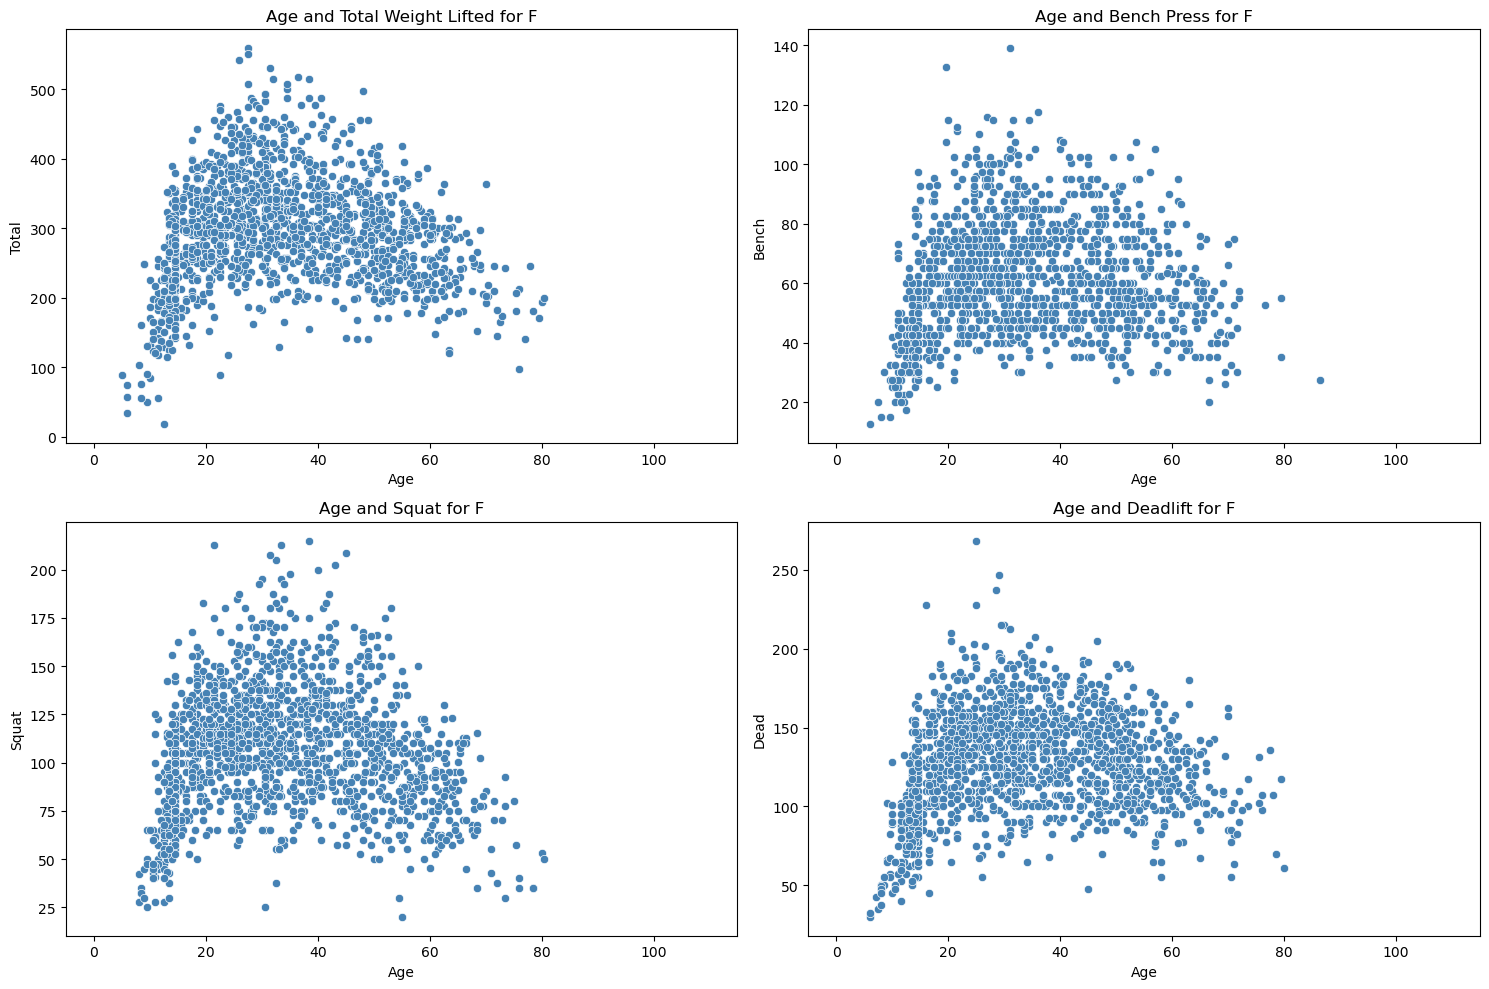

In [14]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Scatter')

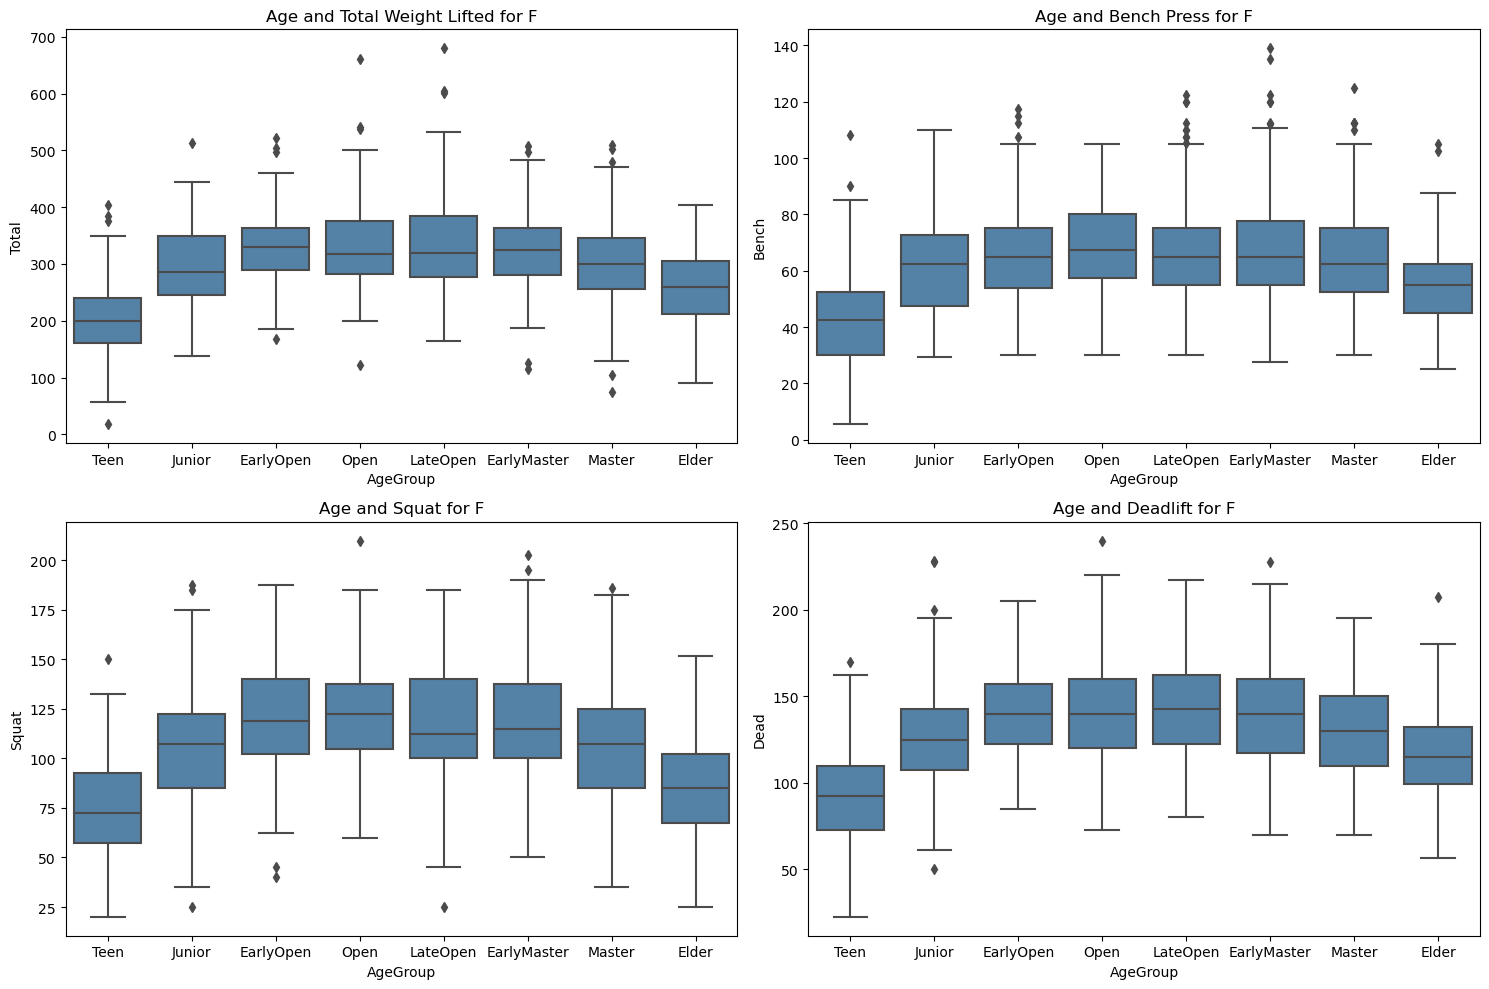

In [15]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Box')

Random Selected Sample Scatter Plot with Hue

In [16]:
def quadrant_hue(total,bench,squat,dead,sex,hue,group):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
    if group == 'Lighter':
        total = total[total['Weight'].isin(['Light','Middle'])]
        dead = dead[dead['Weight'].isin(['Light','Middle'])]
        squat = squat[squat['Weight'].isin(['Light','Middle'])]
        bench = bench[bench['Weight'].isin(['Light','Middle'])]
    elif group == 'Heavier':
        total = total[total['Weight'].isin(['Heavy','SuperHeavy'])]
        dead = dead[dead['Weight'].isin(['Heavy','SuperHeavy'])]
        squat = squat[squat['Weight'].isin(['Heavy','SuperHeavy'])]
        bench = bench[bench['Weight'].isin(['Heavy','SuperHeavy'])]
    
    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)

    hue_order = total[hue].unique()

    palette = sns.color_palette('Accent', n_colors=len(hue_order))

    sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', ax=axs[0, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', ax=axs[0, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', ax=axs[1, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', ax=axs[1, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    plt.tight_layout()

Sex = M

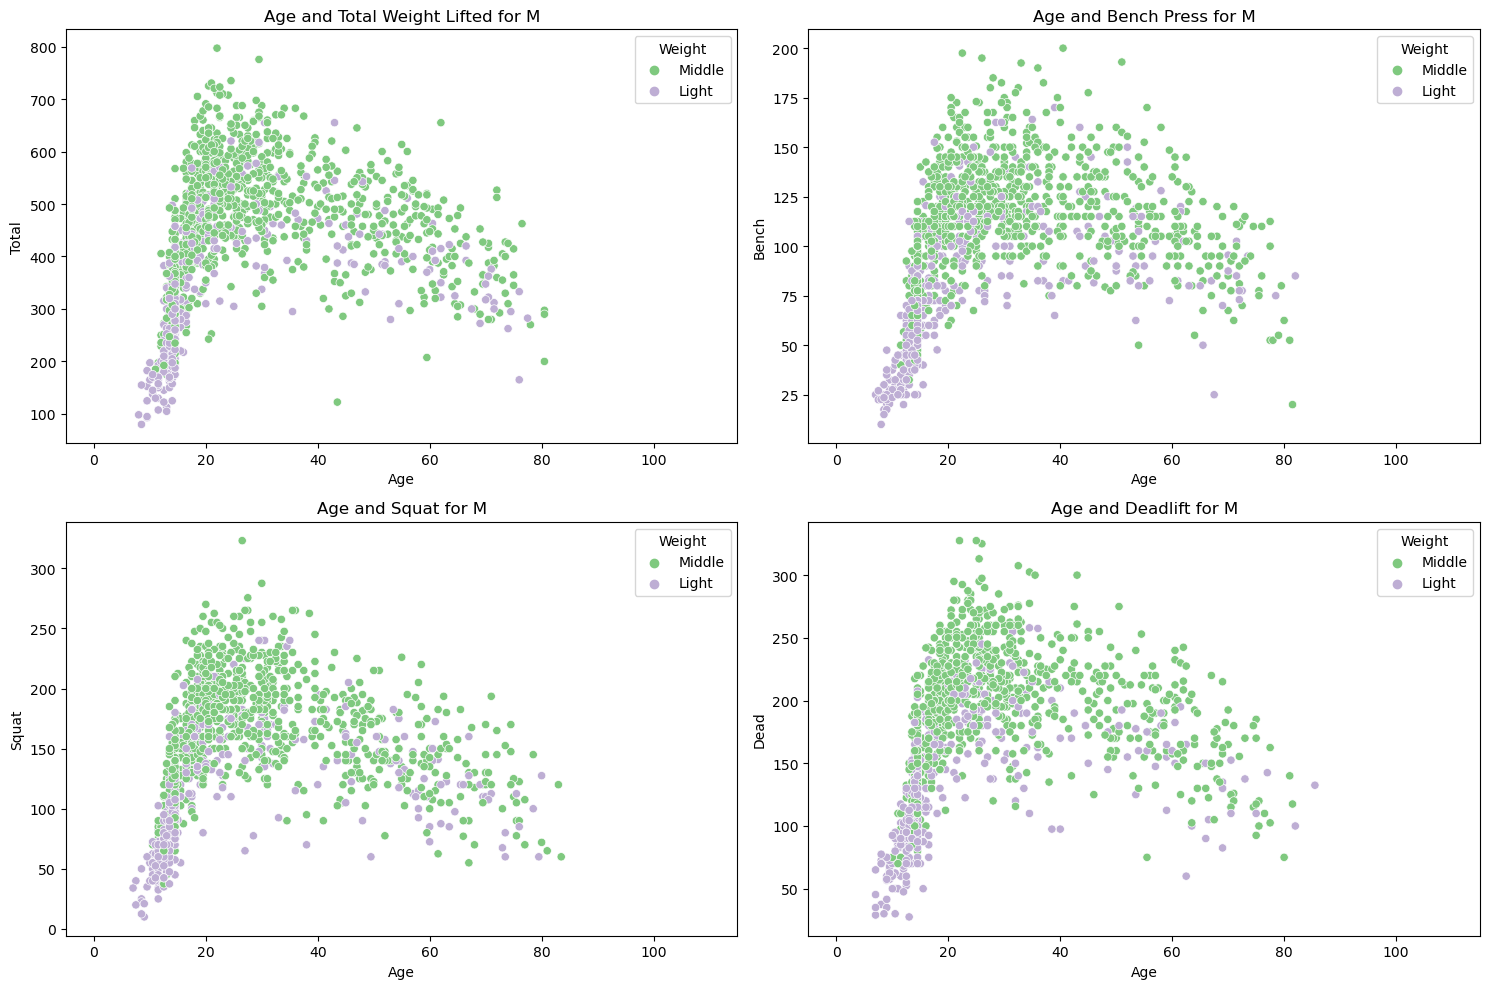

In [17]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Lighter')

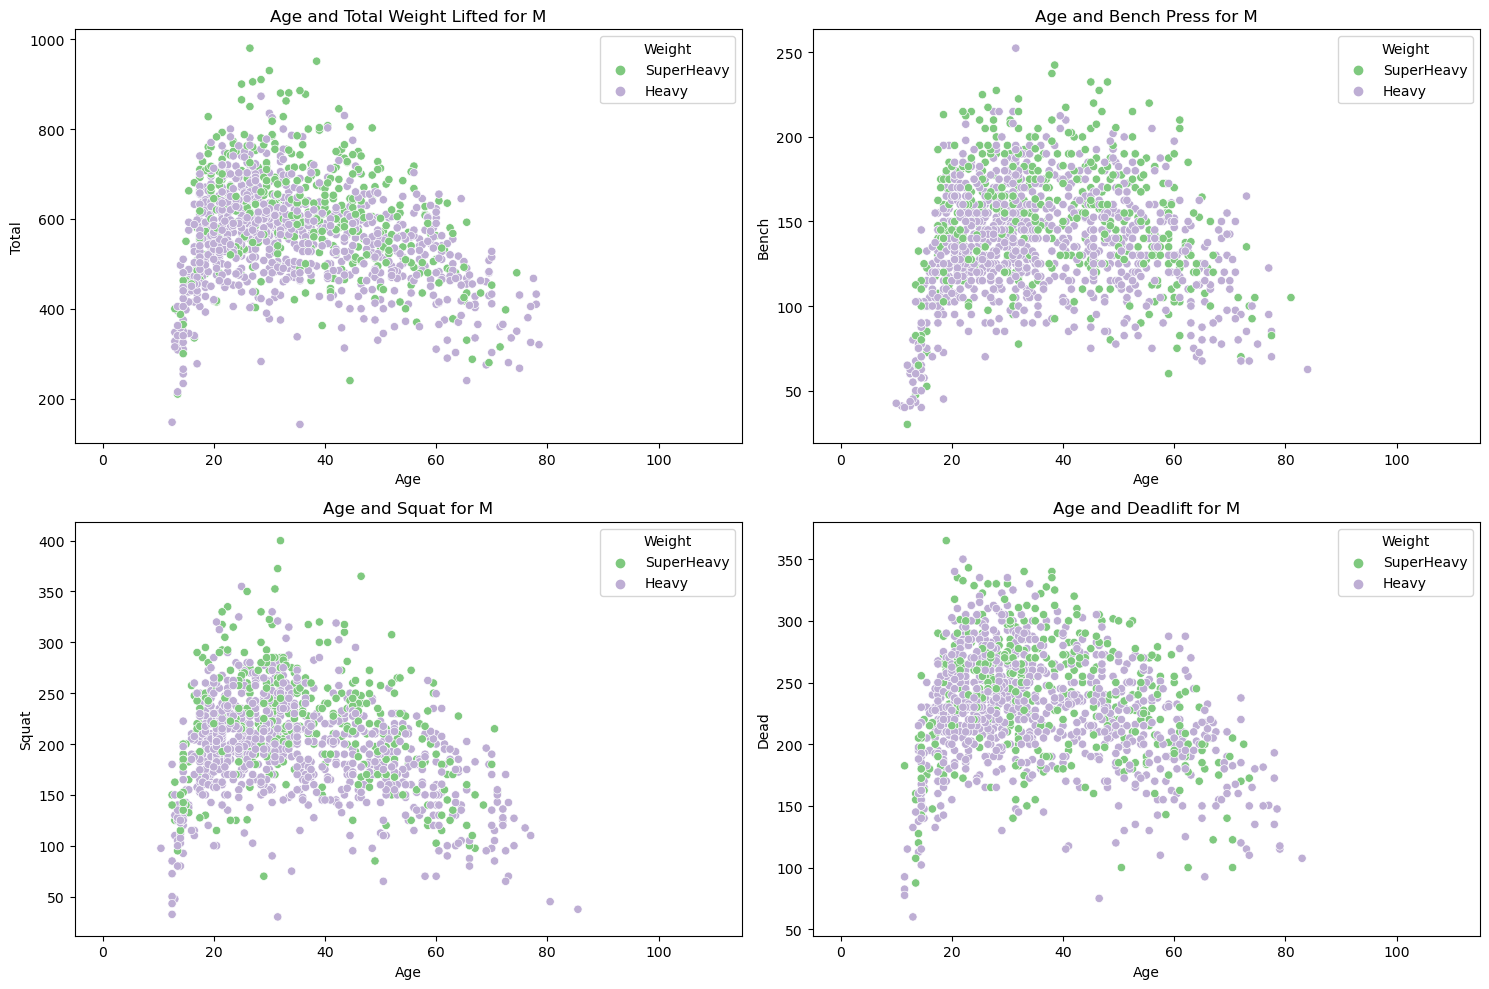

In [18]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Heavier')

Sex = F

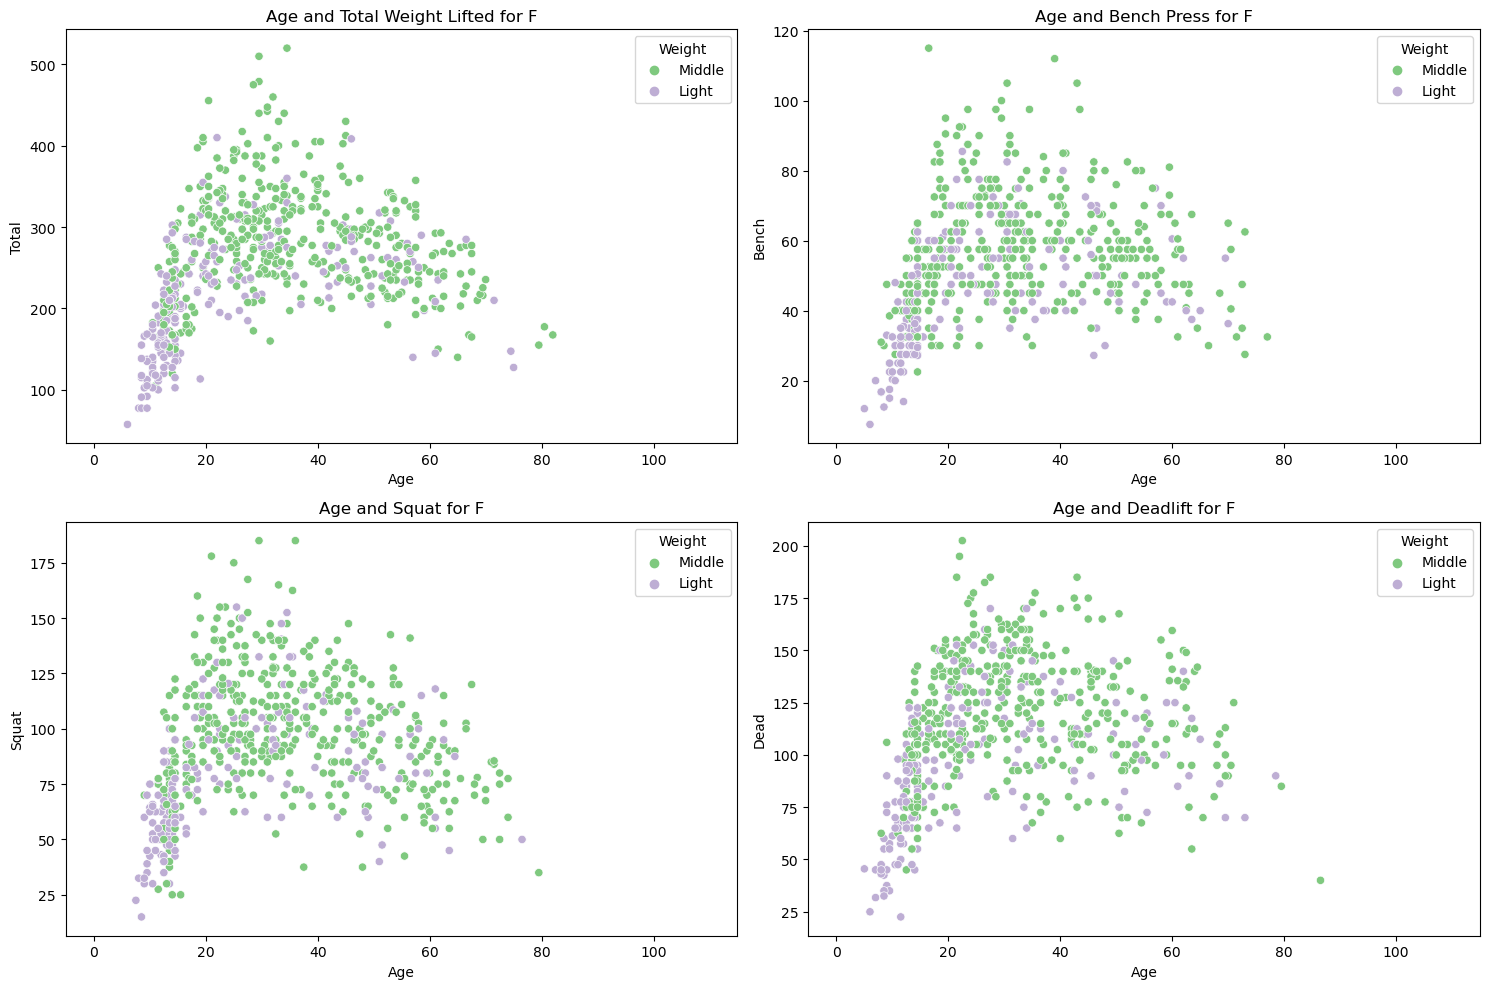

In [19]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Lighter')

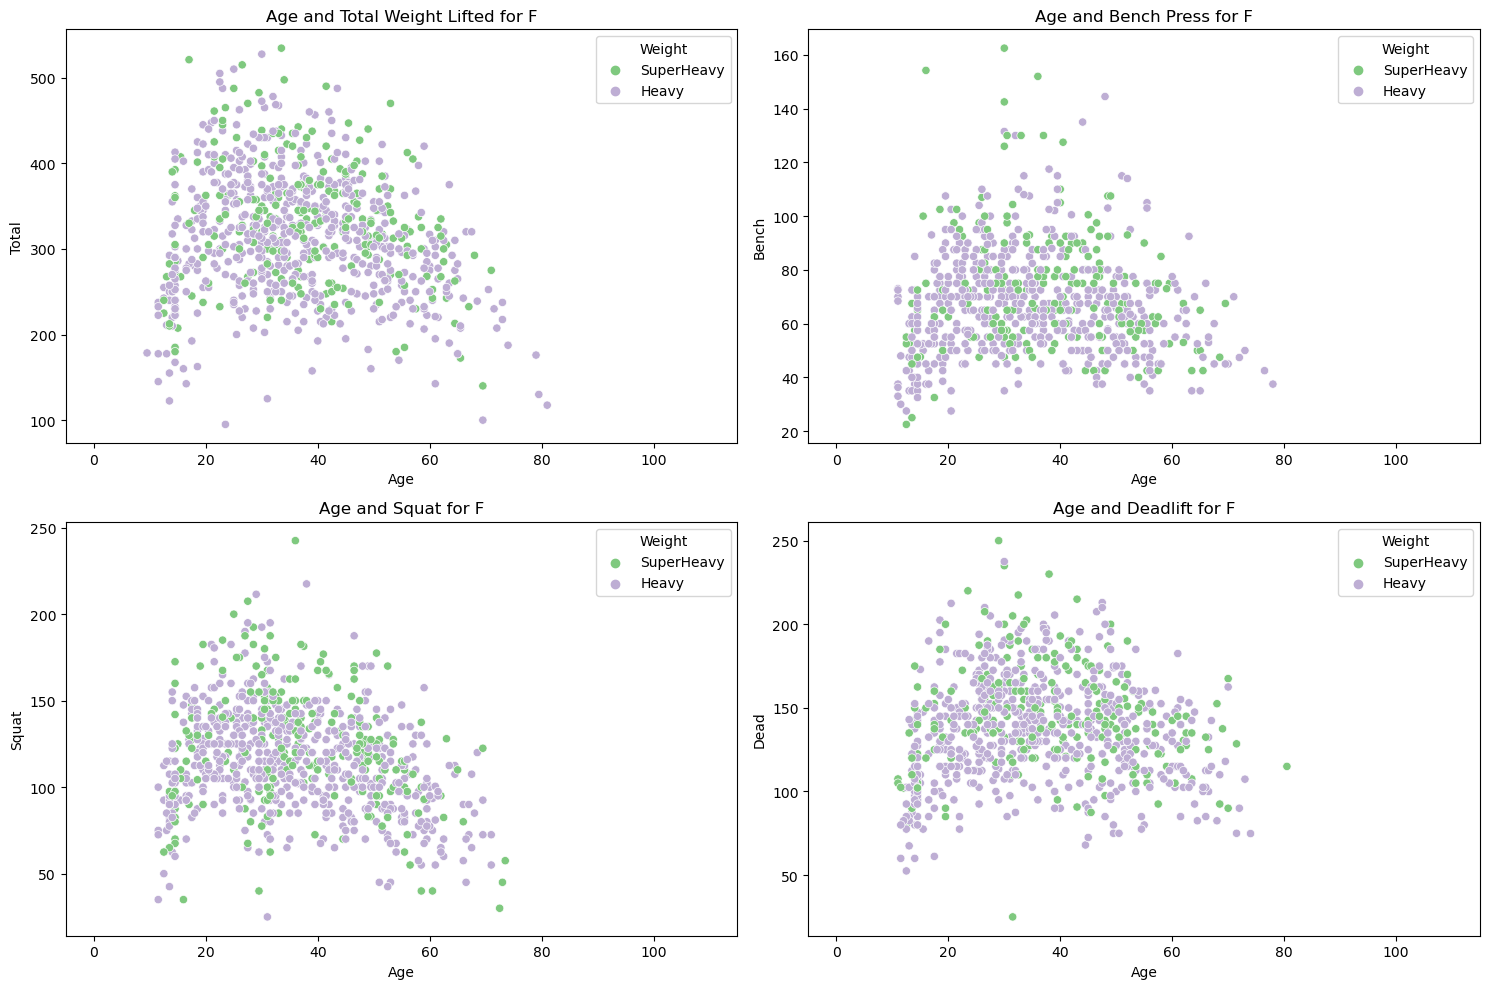

In [20]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Heavier')

# 1) Gaussian Distribution

Explore normality between Age Groups and Peak Strength levels across Total, Bench, Dead, and Squat

In [21]:
def max_strength(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('AgeGroup')[col].quantile(.9).reset_index().copy()
    return cutoff

def shapiro_wilk(total, sex, alpha):
    a = max_strength(total, sex)
    col = total.columns[3]
    stat, p = stats.shapiro(a[col])
    if p > alpha:
        return 'The data appears to be normally distributed (fail to reject H0)'
    else:
        return 'The data does not appear to be normally distributed (reject H0)'
        
def bar_quadrant(total, bench, squat, dead, sex):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    axs[0, 0].set_title('Top Total per Age Group for ' + sex)
    axs[0, 1].set_title('Top Bench Press per Age Group for ' + sex)
    axs[1, 0].set_title('Top Squat per Age Group for ' + sex)
    axs[1, 1].set_title('Top Deadlift per Age Group for ' + sex)

    sns.barplot(max_strength(total, sex), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
    sns.barplot(max_strength(bench, sex), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
    sns.barplot(max_strength(squat, sex), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
    sns.barplot(max_strength(dead, sex), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
    
    total_conclusion = shapiro_wilk(total, sex, alpha=0.05)
    bench_conclusion = shapiro_wilk(bench, sex, alpha=0.05)
    squat_conclusion = shapiro_wilk(squat, sex, alpha=0.05)
    dead_conclusion = shapiro_wilk(dead, sex, alpha=0.05)
    for ax in axs.flat:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    round(bar.get_height(), 2), ha='center', va='bottom')
        
    axs[0, 0].text(0.5, -0.2, total_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 0].transAxes, fontsize=10, color='red')
    axs[0, 1].text(0.5, -0.2, bench_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 1].transAxes, fontsize=10, color='red')
    axs[1, 0].text(0.5, -0.2, squat_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 0].transAxes, fontsize=10, color='red')
    axs[1, 1].text(0.5, -0.2, dead_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 1].transAxes, fontsize=10, color='red')

    plt.tight_layout()


Null Hypothesis: The distribution of Top Strength per Age Group is normally distributed.

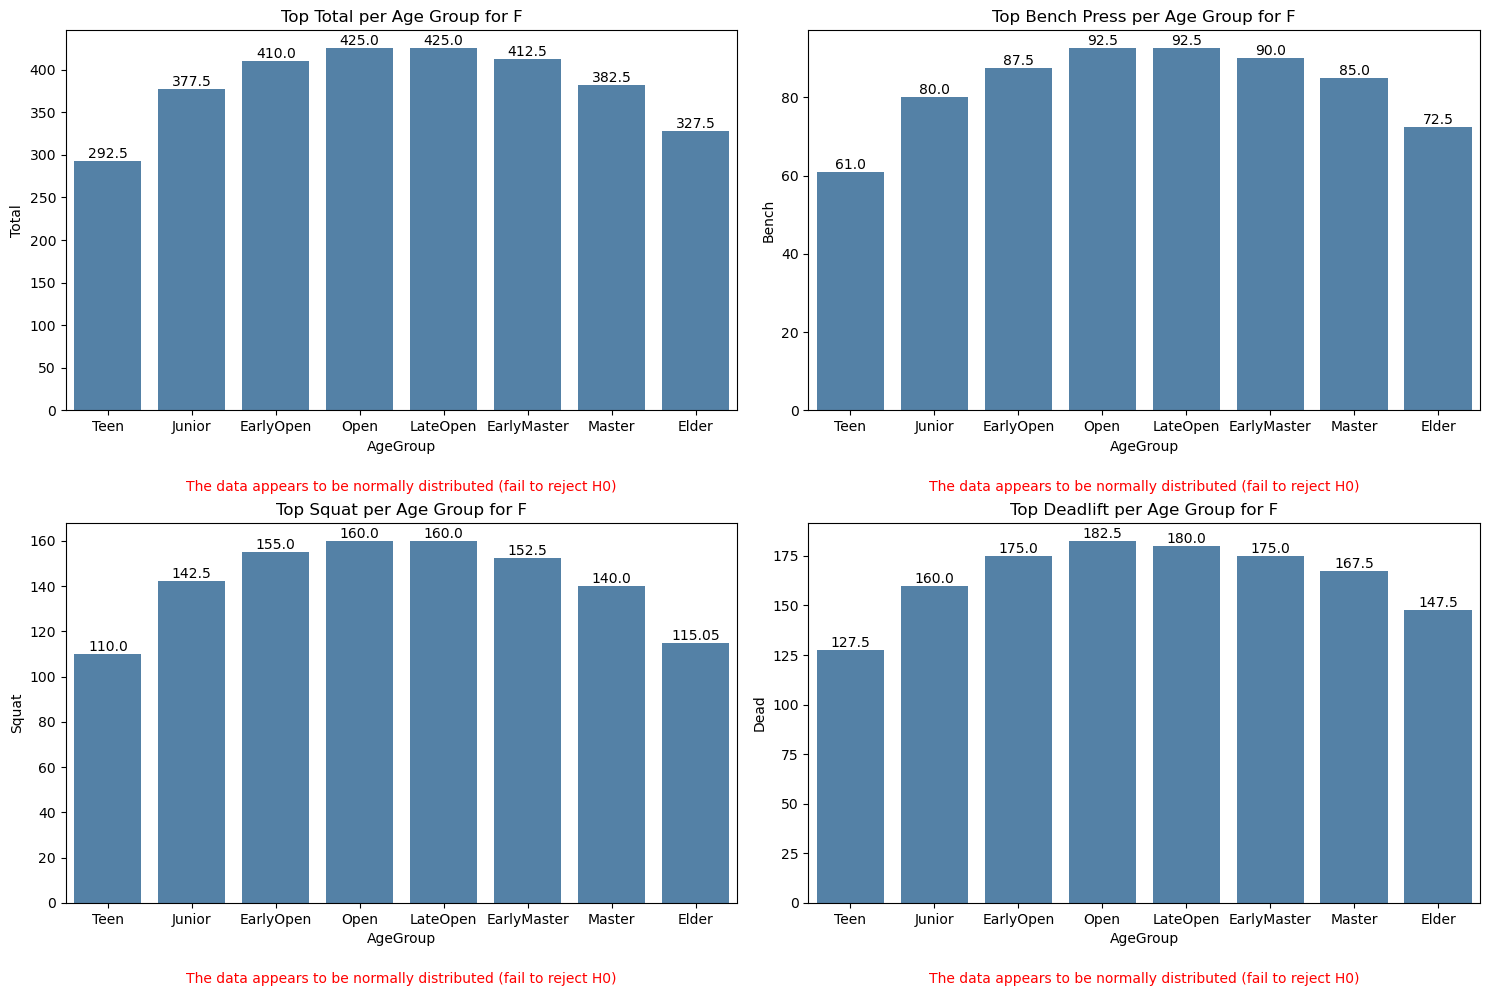

In [22]:
bar_quadrant(total,bench,squat,dead,'F')

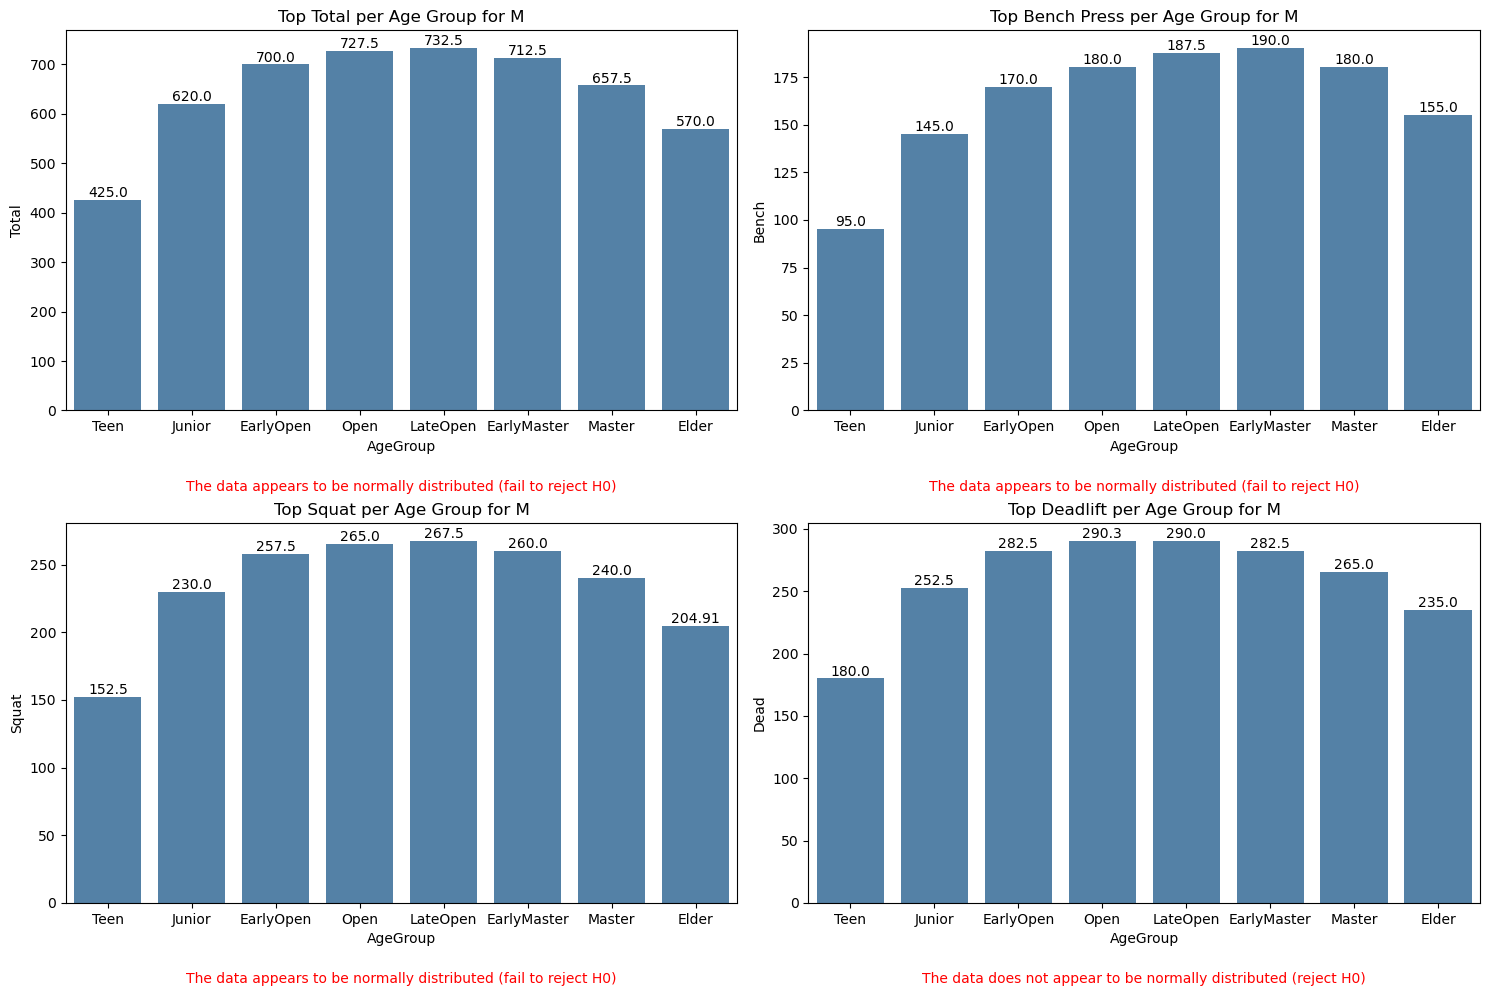

In [23]:
bar_quadrant(total,bench,squat,dead,'M')

# 2) Descriptive Statistical Testing

Top 10% of Total, Bench, Dead, and Squat for each Weight Group
- Statistical testing for difference in means in the top lifters per each weight class

In [89]:
def max_strength_df(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('Weight')[col].quantile(.9).reset_index().copy()
    for x in range(len(cutoff)):
        weight = cutoff.iloc[x,0]
        strength = cutoff.iloc[x,1]
        df = total[total['Sex'] == sex][(total[total['Sex'] == sex]['Weight']==weight)&(total[total['Sex'] == sex][col]>=strength)].copy()
        summary = pd.concat([summary, df], axis = 0, ignore_index = True)
    return summary

def mean_age_difference_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        for j in range(i + 1, len(weight_groups)):
            group1 = weight_groups[i]
            group2 = weight_groups[j]
            sample1 = df[(df['Weight'] == group1) & (df['Sex'] == sex)]['Age']
            sample2 = df[(df['Weight'] == group2) & (df['Sex'] == sex)]['Age']
            z_stat, p_value = ztest(sample1, sample2)

            p_value_formatted = '{:.5f}'.format(p_value) 
            
            if p_value < alpha:
                decision = 'Reject H0: There is a significant difference'
            else:
                decision = 'Fail to reject H0: There is no significant difference'
            
            results[f'{group1} vs {group2}'] = {'Z statistic': z_stat,
                                                 'p-value': p_value_formatted,
                                                 'Decision': decision}
    print(df.groupby('Weight')['Age'].describe())
    return results

def mean_weight_age_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    df = df[df['AgeGroup']!='Teen']
    age_groups = df['AgeGroup'].unique()
    col = df.columns[3]
    top_age = df.groupby('AgeGroup')[col].mean().idxmax()
    age_groups = [x for x in age_groups if (x != top_age)]
    sample1 = df[(df['AgeGroup'] == top_age) & (df['Sex'] == sex)][col]
    for i in range(len(age_groups)):
        group2 = age_groups[i]
        sample2 = df[(df['AgeGroup'] == group2) & (df['Sex'] == sex)][col]
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'{top_age} vs {group2}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    print(df.groupby('AgeGroup')[col].describe())
    return results

Null hypothesis: The mean weight lifted, in peak lifters, of the strongest Age Group is not different than the other Age Groups

Total Weight Lifted

In [90]:
mean_weight_age_z_test(total, 'F', .05)

              count        mean        std    min      25%    50%      75%  \
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN      NaN    NaN      NaN   
Junior        988.0  429.710405  51.473166  332.5  392.500  425.0  457.500   
EarlyOpen    4007.0  427.908440  50.884526  332.5  390.500  422.5  457.500   
Open         3472.0  436.915864  55.246066  332.5  400.000  430.0  465.125   
LateOpen     2045.0  436.821042  54.175699  332.5  400.000  430.0  468.000   
EarlyMaster  1831.0  437.158635  50.187319  332.5  405.000  432.5  467.500   
Master        462.0  438.396753  46.674226  332.5  412.500  432.5  469.625   
Elder          36.0  406.569444  42.901407  338.0  381.375  408.5  426.250   

               max  
AgeGroup            
Teen           NaN  
Junior       612.5  
EarlyOpen    721.5  
Open         708.0  
LateOpen     710.0  
EarlyMaster  667.5  
Master       575.0  
Elder        505.0  


{'Master vs Open': {'Z statistic': 0.5505888119561771,
  'p-value': '0.58192',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Master vs EarlyOpen': {'Z statistic': 4.229897801757175,
  'p-value': '0.00002',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs LateOpen': {'Z statistic': 0.5785162797816061,
  'p-value': '0.56292',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Master vs Junior': {'Z statistic': 3.0826429872142307,
  'p-value': '0.00205',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs EarlyMaster': {'Z statistic': 0.48041466217112994,
  'p-value': '0.63093',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Master vs Elder': {'Z statistic': 3.9625115008995686,
  'p-value': '0.00007',
  'Decision': 'Reject H0: There is a significant difference'}}

In [91]:
mean_weight_age_z_test(total, 'M', .05)

              count        mean        std    min      25%     50%     75%  \
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN      NaN     NaN     NaN   
Junior       1981.0  672.407521  77.675512  525.0  630.000  665.00  720.00   
EarlyOpen    9589.0  701.729633  81.702221  525.0  645.000  705.00  750.00   
Open         6810.0  719.354838  83.155084  525.0  660.000  717.50  777.00   
LateOpen     3401.0  730.538727  88.653303  525.0  667.500  727.50  790.00   
EarlyMaster  2108.0  727.520076  94.624929  525.0  665.000  725.62  790.00   
Master        375.0  705.808533  92.810426  525.0  645.000  710.00  782.50   
Elder          50.0  695.975200  73.793135  535.0  653.125  695.45  752.75   

                max  
AgeGroup             
Teen            NaN  
Junior        920.5  
EarlyOpen    1152.5  
Open         1113.0  
LateOpen     1112.5  
EarlyMaster  1030.0  
Master        895.0  
Elder         817.5  

{'LateOpen vs Open': {'Z statistic': 6.264484189469007,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyOpen': {'Z statistic': 17.271270874204532,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Master': {'Z statistic': 5.102462864173653,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 1.1968736845470276,
  'p-value': '0.23136',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Elder': {'Z statistic': 2.742764951927306,
  'p-value': '0.00609',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 24.26032978792064,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [92]:
mean_weight_age_z_test(squat, 'F', .05)

              count        mean        std    min     25%    50%     75%  \
AgeGroup                                                                   
Teen            0.0         NaN        NaN    NaN     NaN    NaN     NaN   
Junior       1317.0  161.318542  23.535379  120.0  144.00  157.5  175.00   
EarlyOpen    4472.0  159.273884  22.505325  120.0  142.50  157.5  172.50   
Open         3511.0  163.510695  24.771241  120.0  145.00  160.0  177.50   
LateOpen     1967.0  163.574921  24.872297  120.0  145.00  160.0  180.00   
EarlyMaster  1671.0  164.105003  22.331262  120.0  147.50  162.5  180.00   
Master        398.0  163.540980  19.905203  120.0  150.00  160.0  180.00   
Elder          15.0  152.200000  16.954561  120.5  141.75  155.0  161.25   

               max  
AgeGroup            
Teen           NaN  
Junior       265.0  
EarlyOpen    277.5  
Open         300.5  
LateOpen     289.0  
EarlyMaster  280.0  
Master       213.0  
Elder        180.0  


{'EarlyMaster vs Open': {'Z statistic': 0.8328054339530715,
  'p-value': '0.40495',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 7.502795737466329,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 3.3066037983160523,
  'p-value': '0.00094',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 0.6711805749681492,
  'p-value': '0.50211',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 0.46203676503236507,
  'p-value': '0.64405',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 2.059146787170422,
  'p-value': '0.03948',
  'Decision': 'Reject H0: There is a significant difference'}}

In [93]:
mean_weight_age_z_test(squat, 'M', .05)

               count        mean        std    min    25%    50%     75%  \
AgeGroup                                                                   
Teen             0.0         NaN        NaN    NaN    NaN    NaN     NaN   
Junior        2934.0  247.456449  32.375862  187.5  227.5  242.5  265.00   
EarlyOpen    10671.0  257.579165  34.136170  187.5  232.5  257.5  275.00   
Open          6795.0  263.686936  34.654644  187.5  237.5  260.0  285.00   
LateOpen      3310.0  269.188420  38.142371  187.5  242.5  265.0  295.00   
EarlyMaster   2214.0  269.861116  39.810095  187.5  240.0  265.0  295.00   
Master         433.0  261.498430  36.477593  187.5  235.0  260.0  285.00   
Elder           66.0  255.680909  29.635634  187.5  235.0  256.5  268.75   

               max  
AgeGroup            
Teen           NaN  
Junior       425.5  
EarlyOpen    470.0  
Open         478.0  
LateOpen     490.0  
EarlyMaster  455.0  
Master       410.0  
Elder        317.5  


{'EarlyMaster vs Open': {'Z statistic': 7.01043170470107,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 14.951000956453035,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 0.6311702905514848,
  'p-value': '0.52793',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 4.051104246414569,
  'p-value': '0.00005',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 22.253924301382146,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 2.869873846229737,
  'p-value': '0.00411',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [94]:
mean_weight_age_z_test(bench, 'F', .05)

              count        mean        std   min   25%     50%      75%  \
AgeGroup                                                                  
Teen            0.0         NaN        NaN   NaN   NaN     NaN      NaN   
Junior       1486.0   94.738378  14.611541  72.5  85.0   92.50  100.500   
EarlyOpen    4791.0   94.417877  13.207024  72.5  85.0   92.50  102.000   
Open         3899.0   96.162324  14.096344  72.5  85.0   95.00  102.500   
LateOpen     2643.0   98.171351  15.654144  72.5  87.5   95.00  105.000   
EarlyMaster  3053.0   96.831346  13.988275  72.5  87.5   95.00  105.000   
Master       1254.0  100.403915  15.775786  72.5  90.0  100.00  110.000   
Elder         182.0   93.673352   9.868468  72.5  87.5   92.75  102.125   

                max  
AgeGroup             
Teen            NaN  
Junior       172.37  
EarlyOpen    172.50  
Open         165.00  
LateOpen     167.50  
EarlyMaster  152.50  
Master       148.50  
Elder        117.50  


{'Master vs Open': {'Z statistic': 8.996529028914377,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs EarlyOpen': {'Z statistic': 13.695680056563504,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs LateOpen': {'Z statistic': 4.148773812402098,
  'p-value': '0.00003',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs Junior': {'Z statistic': 9.74889492128913,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs EarlyMaster': {'Z statistic': 7.329975802041583,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs Elder': {'Z statistic': 5.597920471116089,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [95]:
mean_weight_age_z_test(bench, 'M', .05)

              count        mean        std    min    25%    50%      75%  \
AgeGroup                                                                   
Teen            0.0         NaN        NaN    NaN    NaN    NaN      NaN   
Junior       1910.0  165.278660  22.129853  127.5  152.5  162.5  180.000   
EarlyOpen    8679.0  173.531873  23.313446  127.5  157.5  175.0  187.500   
Open         7844.0  180.334997  24.745458  127.5  162.5  180.0  197.125   
LateOpen     5670.0  184.547111  25.924429  127.5  165.0  182.5  202.500   
EarlyMaster  6375.0  188.958602  26.048422  127.5  175.0  187.5  205.000   
Master       2280.0  186.241539  26.421131  127.5  165.0  185.0  205.000   
Elder         509.0  180.978448  26.359296  127.5  160.0  180.0  200.000   

                max  
AgeGroup             
Teen            NaN  
Junior       238.14  
EarlyOpen    275.00  
Open         300.00  
LateOpen     295.00  
EarlyMaster  291.50  
Master       272.50  
Elder        254.01  


{'EarlyMaster vs Open': {'Z statistic': 20.183310103434668,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 38.15918151369255,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 9.298335620590114,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 4.258436148885867,
  'p-value': '0.00002',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Elder': {'Z statistic': 6.64544239348486,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 36.02475718922548,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Dead

In [96]:
mean_weight_age_z_test(dead, 'F', .05)

              count        mean        std    min    25%      50%    75%  \
AgeGroup                                                                   
Teen            0.0         NaN        NaN    NaN    NaN      NaN    NaN   
Junior        992.0  181.250625  17.130016  145.0  170.0  180.000  190.0   
EarlyOpen    4218.0  181.853634  18.950516  145.0  167.5  182.500  192.5   
Open         3789.0  185.826854  20.148718  145.0  172.5  185.000  195.0   
LateOpen     2291.0  185.514766  20.323126  145.0  170.0  185.000  195.0   
EarlyMaster  2439.0  185.186876  19.409043  145.0  172.5  185.000  195.0   
Master        692.0  184.300029  16.879661  145.0  172.5  185.000  192.5   
Elder          88.0  178.601477  18.919837  145.0  162.5  181.215  190.0   

               max  
AgeGroup            
Teen           NaN  
Junior       240.0  
EarlyOpen    272.5  
Open         272.5  
LateOpen     267.5  
EarlyMaster  246.0  
Master       255.0  
Elder        230.0  


{'Open vs EarlyOpen': {'Z statistic': 9.090649650578362,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Open vs EarlyMaster': {'Z statistic': 1.2411618096988246,
  'p-value': '0.21455',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Open vs LateOpen': {'Z statistic': 0.5833567900708881,
  'p-value': '0.55965',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Open vs Elder': {'Z statistic': 3.3300147215448352,
  'p-value': '0.00087',
  'Decision': 'Reject H0: There is a significant difference'},
 'Open vs Junior': {'Z statistic': 6.559549587522006,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Open vs Master': {'Z statistic': 1.8767033160872861,
  'p-value': '0.06056',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [97]:
mean_weight_age_z_test(dead, 'M', .05)

               count        mean        std    min    25%    50%    75%    max
AgeGroup                                                                      
Teen             0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN
Junior        2589.0  274.401560  28.488798  220.0  260.0  275.0  292.5  365.0
EarlyOpen    10906.0  286.988784  29.225845  220.0  267.5  287.5  305.0  410.0
Open          7653.0  292.664954  29.207944  220.0  272.5  292.5  310.0  400.5
LateOpen      3715.0  295.453015  30.528957  220.0  275.0  295.0  315.0  401.0
EarlyMaster   2534.0  294.365651  30.361051  220.0  277.5  295.0  315.0  392.5
Master         574.0  284.596777  28.755920  220.0  265.0  287.5  305.0  367.5
Elder           96.0  277.361354  19.625879  220.0  269.5  277.5  290.0  312.5


{'LateOpen vs EarlyOpen': {'Z statistic': 15.072045085811896,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Master': {'Z statistic': 7.989562452494852,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Open': {'Z statistic': 4.703143948947646,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 1.3855056390816545,
  'p-value': '0.16590',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Elder': {'Z statistic': 5.77514833270696,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Junior': {'Z statistic': 27.678630564793593,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in all Weight Groups of the same Sex are not different.

Total Weight Lifted

In [33]:
mean_age_difference_z_test(total,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       9185.0  26.887153  6.309536  16.5  22.5  25.5  30.0  63.0
Light       2657.0  26.063794  7.069309  14.5  21.5  24.0  29.0  60.5
Middle      8861.0  25.554960  5.905045  15.0  21.5  24.0  28.5  65.0
SuperHeavy  3612.0  28.739064  6.684887  16.5  23.5  27.5  32.5  57.0


{'Heavy vs Light': {'Z statistic': 5.761297041368589,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 14.632322250768873,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -14.692669903136979,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 3.7146887788062375,
  'p-value': '0.00020',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -15.279868569668592,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -26.264847199027574,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [34]:
mean_age_difference_z_test(total,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       5546.0  28.236477  7.501104  13.0  22.5  26.5  32.0  59.0
Light       1513.0  27.948116  7.085442  15.5  22.5  26.5  31.5  61.0
Middle      3884.0  27.424305  6.966981  14.5  22.5  25.5  31.0  58.0
SuperHeavy  1903.0  30.451130  8.306844  14.5  24.0  29.0  36.0  54.0


{'Heavy vs Light': {'Z statistic': 1.340974057744777,
  'p-value': '0.17993',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.32770939950217,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -10.805272932903339,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 2.4690852517926665,
  'p-value': '0.01355',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -9.32888295564605,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -14.550755172626431,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [35]:
mean_age_difference_z_test(squat,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       9961.0  26.605511  6.685758  15.5  22.0  25.0  29.5  64.0
Light       2665.0  25.352908  6.772924  14.5  20.5  23.5  28.0  60.5
Middle      9797.0  25.231295  6.124669  15.0  21.5  23.5  28.0  65.0
SuperHeavy  4004.0  28.131119  6.888873  15.5  22.5  27.0  32.0  57.0


{'Heavy vs Light': {'Z statistic': 8.56704010954674,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 15.058241627030263,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -12.088258472828002,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 0.8879505082820726,
  'p-value': '0.37457',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -16.240449169084506,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -24.324153153149233,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [36]:
mean_age_difference_z_test(squat,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       5582.0  27.563149  7.304313  14.0  22.5  26.0  31.0  59.0
Light       1662.0  27.188327  6.827255  14.5  22.5  25.5  30.5  56.5
Middle      4189.0  26.821198  6.783220  14.5  22.0  25.0  30.0  56.5
SuperHeavy  1933.0  29.101914  8.220906  14.5  23.0  27.5  34.0  54.0


{'Heavy vs Light': {'Z statistic': 1.863602038065117,
  'p-value': '0.06238',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 5.122457889542198,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -7.722075326134775,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 1.8635308885656379,
  'p-value': '0.06239',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -7.518564903254812,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -11.412714432996692,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [37]:
mean_age_difference_z_test(bench,'M',.05)

              count       mean       std   min   25%   50%   75%   max
Weight                                                                
Heavy       11997.0  30.985371  8.922701  15.0  24.0  29.0  36.0  76.0
Light        3615.0  28.631950  8.972465  13.0  22.0  26.0  33.5  71.5
Middle      11394.0  28.682859  8.534981  14.5  22.5  26.5  32.5  66.5
SuperHeavy   6263.0  33.993533  8.909433  16.5  27.0  33.0  40.0  66.5


{'Heavy vs Light': {'Z statistic': 13.883625740077946,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 20.14836797951433,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -21.637320749490137,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -0.3085888251788602,
  'p-value': '0.75763',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -28.736139558417218,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -38.94208385048271,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [38]:
mean_age_difference_z_test(bench,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       7074.0  29.803859  9.372328  13.0  22.5  27.5  35.0  67.5
Light       2104.0  28.753089  8.335567  13.0  22.5  27.0  33.0  61.0
Middle      5723.0  28.696837  8.562725  12.0  22.5  26.5  33.5  65.0
SuperHeavy  2434.0  33.284717  9.318731  14.0  26.0  32.0  40.0  59.5


{'Heavy vs Light': {'Z statistic': 4.627007730595697,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 6.903602880998979,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -15.827842660070822,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 0.2595017522653948,
  'p-value': '0.79525',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -17.150039959755993,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -21.55654328148377,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Deadlift

In [39]:
mean_age_difference_z_test(dead,'M',.05)

              count       mean       std   min   25%   50%   75%   max
Weight                                                                
Heavy       10742.0  26.819261  6.641997  15.5  22.5  25.5  29.5  64.0
Light        3195.0  25.642410  7.317391  14.0  21.0  23.5  28.5  59.5
Middle       9767.0  25.821081  6.578505  15.0  21.5  24.0  28.5  65.0
SuperHeavy   4368.0  28.860234  6.829257  16.5  23.5  27.5  33.0  61.5


{'Heavy vs Light': {'Z statistic': 8.58482904931073,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 10.797855489244428,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -16.98362481902734,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -1.295292436657789,
  'p-value': '0.19522',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -19.63561646097714,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -25.081198137797433,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [40]:
mean_age_difference_z_test(dead,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       6019.0  28.945506  7.990644  13.0  23.0  27.0  33.0  61.0
Light       1831.0  28.548607  7.745938  13.5  22.5  26.5  33.0  63.5
Middle      4333.0  28.402146  7.751627  14.5  22.5  26.5  32.0  62.0
SuperHeavy  2336.0  31.438142  8.843701  14.5  25.0  30.0  37.0  62.0


{'Heavy vs Light': {'Z statistic': 1.874324378544152,
  'p-value': '0.06089',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 3.455994396555523,
  'p-value': '0.00055',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -12.412580270935543,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 0.6780020052351403,
  'p-value': '0.49777',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -11.048396794914195,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -14.511181385681006,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in each Weight Group are the same across Sex.

In [41]:
def mean_age_difference_z_test_2(total, alpha):
    results = {}
    df1 = max_strength_df(total, 'M')
    df2 = max_strength_df(total,'F')
    
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        weight = weight_groups[i]
        sample1 = df1[df1['Weight']==weight]['Age'].copy()
        sample2 = df2[df2['Weight']==weight]['Age'].copy()
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'F v M in {weight}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    dfs = pd.concat([df2.groupby('Weight')['Age'].mean(),
           df1.groupby('Weight')['Age'].mean()], axis = 1)
    dfs['Delta'] = dfs.iloc[:,0]-dfs.iloc[:,1]
    dfs.columns = ['F mean age','M mean age', 'Delta']
    print(dfs)
    return results

In [42]:
mean_age_difference_z_test_2(total,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        28.236477   26.887153  1.349324
Light        27.948116   26.063794  1.884323
Middle       27.424305   25.554960  1.869345
SuperHeavy   30.451130   28.739064  1.712066


{'F v M in Middle': {'Z statistic': -15.547999130005975,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -11.698348881755066,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -8.29637981391297,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -8.269244872568857,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [43]:
mean_age_difference_z_test_2(squat,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        27.563149   26.605511  0.957638
Light        27.188327   25.352908  1.835419
Middle       26.821198   25.231295  1.589903
SuperHeavy   29.101914   28.131119  0.970795


{'F v M in Middle': {'Z statistic': -13.607693658658441,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -8.283894242942923,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -4.76954117355748,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -8.643518587140528,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [44]:
mean_age_difference_z_test_2(bench,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        29.803859   30.985371 -1.181512
Light        28.753089   28.631950  0.121139
Middle       28.696837   28.682859  0.013978
SuperHeavy   33.284717   33.993533 -0.708817


{'F v M in Middle': {'Z statistic': -0.10097271594334098,
  'p-value': '0.91957',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in Heavy': {'Z statistic': 8.668771636005815,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': 3.2878623281146115,
  'p-value': '0.00101',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -0.505256944726565,
  'p-value': '0.61338',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [45]:
mean_age_difference_z_test_2(dead,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        28.945506   26.819261  2.126245
Light        28.548607   25.642410  2.906197
Middle       28.402146   25.821081  2.581065
SuperHeavy   31.438142   28.860234  2.577909


{'F v M in Middle': {'Z statistic': -20.31662818111277,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -18.45535682430628,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -13.247116222429977,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -13.261869069481477,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

# 3) Peak Age Linear Regression Testing

Exploring the relationship leading up to and after the Peak Age per Weight Group for top strength levels

In [46]:
def pre_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]

    a['high'] = a['mean']-a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        high = a.iloc[x,2]
        high_df = aa[(aa['Weight']== a.index[x])&(aa['Age']<=high)].copy()
        high_r = stats.linregress(high_df['Age'],high_df[col])
        results[f'{col} and Age Pre-Peak Age for {weight} {sex}'] = {'Peak-Age':round(high,2),
                                                                     'Slope':round(stats.linregress(high_df['Age'],high_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(high_df['Age'],high_df[col])[3]),
                                                                'R':round(stats.linregress(high_df['Age'],high_df[col])[2],2)}
    return results

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters leading up to Peak Age

Sex: M

In [47]:
pre_peak_lin(total,'M')

{'Total and Age Pre-Peak Age for Heavy M': {'Peak-Age': 20.58,
  'Slope': 2.44,
  'p-value': '0.01563',
  'R': 0.08},
 'Total and Age Pre-Peak Age for Light M': {'Peak-Age': 18.99,
  'Slope': 1.91,
  'p-value': '0.31959',
  'R': 0.07},
 'Total and Age Pre-Peak Age for Middle M': {'Peak-Age': 19.65,
  'Slope': 2.2,
  'p-value': '0.03022',
  'R': 0.07},
 'Total and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 22.05,
  'Slope': 3.69,
  'p-value': '0.02066',
  'R': 0.1}}

In [48]:
pre_peak_lin(squat,'M')

{'Squat and Age Pre-Peak Age for Heavy M': {'Peak-Age': 19.92,
  'Slope': 2.08,
  'p-value': '0.00009',
  'R': 0.13},
 'Squat and Age Pre-Peak Age for Light M': {'Peak-Age': 18.58,
  'Slope': 0.41,
  'p-value': '0.53055',
  'R': 0.04},
 'Squat and Age Pre-Peak Age for Middle M': {'Peak-Age': 19.11,
  'Slope': 1.04,
  'p-value': '0.02489',
  'R': 0.07},
 'Squat and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 21.24,
  'Slope': 2.9,
  'p-value': '0.00034',
  'R': 0.15}}

In [49]:
pre_peak_lin(bench,'M')

{'Bench and Age Pre-Peak Age for Heavy M': {'Peak-Age': 22.06,
  'Slope': 0.74,
  'p-value': '0.00001',
  'R': 0.11},
 'Bench and Age Pre-Peak Age for Light M': {'Peak-Age': 19.66,
  'Slope': 1.31,
  'p-value': '0.00345',
  'R': 0.14},
 'Bench and Age Pre-Peak Age for Middle M': {'Peak-Age': 20.15,
  'Slope': 0.99,
  'p-value': '0.00061',
  'R': 0.1},
 'Bench and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 25.08,
  'Slope': 0.96,
  'p-value': '0.00002',
  'R': 0.13}}

In [50]:
pre_peak_lin(dead,'M')

{'Dead and Age Pre-Peak Age for Heavy M': {'Peak-Age': 20.18,
  'Slope': 1.84,
  'p-value': '0.00018',
  'R': 0.12},
 'Dead and Age Pre-Peak Age for Light M': {'Peak-Age': 18.33,
  'Slope': 1.68,
  'p-value': '0.02499',
  'R': 0.14},
 'Dead and Age Pre-Peak Age for Middle M': {'Peak-Age': 19.24,
  'Slope': 0.3,
  'p-value': '0.60356',
  'R': 0.02},
 'Dead and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 22.03,
  'Slope': 0.79,
  'p-value': '0.10448',
  'R': 0.06}}

Sex: F

In [51]:
pre_peak_lin(total,'F')

{'Total and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.74,
  'Slope': 6.51,
  'p-value': '0.00000',
  'R': 0.25},
 'Total and Age Pre-Peak Age for Light F': {'Peak-Age': 20.86,
  'Slope': 6.09,
  'p-value': '0.00045',
  'R': 0.28},
 'Total and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.46,
  'Slope': 3.62,
  'p-value': '0.00010',
  'R': 0.2},
 'Total and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 22.14,
  'Slope': 0.76,
  'p-value': '0.56104',
  'R': 0.03}}

In [52]:
pre_peak_lin(squat,'F')

{'Squat and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.26,
  'Slope': 2.26,
  'p-value': '0.00000',
  'R': 0.23},
 'Squat and Age Pre-Peak Age for Light F': {'Peak-Age': 20.36,
  'Slope': 1.54,
  'p-value': '0.00067',
  'R': 0.26},
 'Squat and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.04,
  'Slope': 0.68,
  'p-value': '0.02607',
  'R': 0.1},
 'Squat and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 20.88,
  'Slope': 0.25,
  'p-value': '0.69676',
  'R': 0.02}}

In [53]:
pre_peak_lin(bench,'F')

{'Bench and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.43,
  'Slope': 1.12,
  'p-value': '0.00001',
  'R': 0.16},
 'Bench and Age Pre-Peak Age for Light F': {'Peak-Age': 20.42,
  'Slope': 0.84,
  'p-value': '0.02661',
  'R': 0.15},
 'Bench and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.13,
  'Slope': 0.68,
  'p-value': '0.01072',
  'R': 0.1},
 'Bench and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 23.97,
  'Slope': -1.47,
  'p-value': '0.00001',
  'R': -0.21}}

In [54]:
pre_peak_lin(dead,'F')

{'Dead and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.95,
  'Slope': 2.15,
  'p-value': '0.00000',
  'R': 0.21},
 'Dead and Age Pre-Peak Age for Light F': {'Peak-Age': 20.8,
  'Slope': 1.79,
  'p-value': '0.00008',
  'R': 0.28},
 'Dead and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.65,
  'Slope': 1.38,
  'p-value': '0.00006',
  'R': 0.18},
 'Dead and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 22.59,
  'Slope': 0.69,
  'p-value': '0.03618',
  'R': 0.11}}

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters after to Peak Age

In [55]:
def post_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]
    a['low'] = a['mean']+a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        low = a.iloc[x,2]
        low_df = aa[(aa['Weight']== a.index[x])&(aa['Age']>=low)].copy()
        low_r = stats.linregress(low_df['Age'],low_df[col])
        results[f'{col} and Age Post-Peak Age for {weight} {sex}'] = {'Peak-Age':round(low,2),
                                                                      'Slope':round(stats.linregress(low_df['Age'],low_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(low_df['Age'],low_df[col])[3]),
                                                                'R':round(stats.linregress(low_df['Age'],low_df[col])[2],2)}
    return results

Sex: M

In [56]:
post_peak_lin(total,'M')

{'Total and Age Post-Peak Age for Heavy M': {'Peak-Age': 33.2,
  'Slope': -0.11,
  'p-value': '0.56417',
  'R': -0.02},
 'Total and Age Post-Peak Age for Light M': {'Peak-Age': 33.13,
  'Slope': -1.45,
  'p-value': '0.00004',
  'R': -0.21},
 'Total and Age Post-Peak Age for Middle M': {'Peak-Age': 31.46,
  'Slope': -0.88,
  'p-value': '0.00000',
  'R': -0.13},
 'Total and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 35.42,
  'Slope': -2.37,
  'p-value': '0.00000',
  'R': -0.2}}

In [57]:
post_peak_lin(squat,'M')

{'Squat and Age Post-Peak Age for Heavy M': {'Peak-Age': 33.29,
  'Slope': -0.18,
  'p-value': '0.01752',
  'R': -0.06},
 'Squat and Age Post-Peak Age for Light M': {'Peak-Age': 32.13,
  'Slope': -0.83,
  'p-value': '0.00000',
  'R': -0.27},
 'Squat and Age Post-Peak Age for Middle M': {'Peak-Age': 31.36,
  'Slope': -0.42,
  'p-value': '0.00000',
  'R': -0.17},
 'Squat and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 35.02,
  'Slope': -0.75,
  'p-value': '0.00261',
  'R': -0.12}}

In [58]:
post_peak_lin(bench,'M')

{'Bench and Age Post-Peak Age for Heavy M': {'Peak-Age': 39.91,
  'Slope': -0.23,
  'p-value': '0.00001',
  'R': -0.1},
 'Bench and Age Post-Peak Age for Light M': {'Peak-Age': 37.6,
  'Slope': -0.76,
  'p-value': '0.00000',
  'R': -0.33},
 'Bench and Age Post-Peak Age for Middle M': {'Peak-Age': 37.22,
  'Slope': -0.45,
  'p-value': '0.00000',
  'R': -0.22},
 'Bench and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 42.9,
  'Slope': -0.18,
  'p-value': '0.07016',
  'R': -0.06}}

In [59]:
post_peak_lin(dead,'M')

{'Dead and Age Post-Peak Age for Heavy M': {'Peak-Age': 33.46,
  'Slope': -0.35,
  'p-value': '0.00000',
  'R': -0.13},
 'Dead and Age Post-Peak Age for Light M': {'Peak-Age': 32.96,
  'Slope': -0.3,
  'p-value': '0.01739',
  'R': -0.11},
 'Dead and Age Post-Peak Age for Middle M': {'Peak-Age': 32.4,
  'Slope': -0.37,
  'p-value': '0.00000',
  'R': -0.16},
 'Dead and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 35.69,
  'Slope': -0.66,
  'p-value': '0.00001',
  'R': -0.17}}

Sex: F

In [60]:
post_peak_lin(total,'F')

{'Total and Age Post-Peak Age for Heavy F': {'Peak-Age': 35.74,
  'Slope': -0.51,
  'p-value': '0.02311',
  'R': -0.08},
 'Total and Age Post-Peak Age for Light F': {'Peak-Age': 35.03,
  'Slope': 0.39,
  'p-value': '0.23706',
  'R': 0.08},
 'Total and Age Post-Peak Age for Middle F': {'Peak-Age': 34.39,
  'Slope': -0.92,
  'p-value': '0.00004',
  'R': -0.17},
 'Total and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 38.76,
  'Slope': -0.57,
  'p-value': '0.15047',
  'R': -0.08}}

In [61]:
post_peak_lin(squat,'F')

{'Squat and Age Post-Peak Age for Heavy F': {'Peak-Age': 34.87,
  'Slope': -0.31,
  'p-value': '0.00027',
  'R': -0.12},
 'Squat and Age Post-Peak Age for Light F': {'Peak-Age': 34.02,
  'Slope': 0.24,
  'p-value': '0.09708',
  'R': 0.11},
 'Squat and Age Post-Peak Age for Middle F': {'Peak-Age': 33.6,
  'Slope': -0.5,
  'p-value': '0.00000',
  'R': -0.2},
 'Squat and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 37.32,
  'Slope': -0.34,
  'p-value': '0.00794',
  'R': -0.14}}

In [62]:
post_peak_lin(bench,'F')

{'Bench and Age Post-Peak Age for Heavy F': {'Peak-Age': 39.18,
  'Slope': 0.09,
  'p-value': '0.12781',
  'R': 0.04},
 'Bench and Age Post-Peak Age for Light F': {'Peak-Age': 37.09,
  'Slope': -0.22,
  'p-value': '0.03440',
  'R': -0.12},
 'Bench and Age Post-Peak Age for Middle F': {'Peak-Age': 37.26,
  'Slope': 0.01,
  'p-value': '0.92978',
  'R': 0.0},
 'Bench and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 42.6,
  'Slope': 0.18,
  'p-value': '0.25085',
  'R': 0.05}}

In [63]:
post_peak_lin(dead,'F')

{'Dead and Age Post-Peak Age for Heavy F': {'Peak-Age': 36.94,
  'Slope': -0.16,
  'p-value': '0.05077',
  'R': -0.06},
 'Dead and Age Post-Peak Age for Light F': {'Peak-Age': 36.29,
  'Slope': -0.05,
  'p-value': '0.60570',
  'R': -0.03},
 'Dead and Age Post-Peak Age for Middle F': {'Peak-Age': 36.15,
  'Slope': -0.34,
  'p-value': '0.00001',
  'R': -0.17},
 'Dead and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 40.28,
  'Slope': -0.19,
  'p-value': '0.12450',
  'R': -0.08}}

# 4) Peak Age Polynomial Regression Testing

In [78]:
def pord(total, sex, deg):
    col = total.columns[3]
    a = total[total['Sex'] == sex].groupby('Age')[col].mean().reset_index().copy()
    X = a['Age']
    Y = a[col]
    poly_model = odr.polynomial(deg)
    data = odr.Data(X, Y)

    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()

    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(X)
    plt.plot(X, Y, label='Weight Lifted')
    plt.plot(X, poly_y, label='Polynomial ODR')
    plt.xlabel('Age')
    plt.ylabel('Weight Lifted')
    plt.legend()
    print('Peak Mean Weight Lifted is at: '+str(X[poly_y.argmax()])+' years old.')
    degf = len(X)-2
    beta_0 = 0
    stat = (output.beta[0] - beta_0) / output.sd_beta[0]
    p_val = stats.t.sf(np.abs(stat), degf) * 2
    print('Recovered equation: y={:3.2f}x + {:3.2f}, t={:3.2f}, p={:.2e}'.format(output.beta[0], output.beta[1], stat, p_val))
    print('R_Squared: '+str(1 - (np.var((Y - poly_y)) / np.var(Y))))

Total Weight Lifted

Peak Mean Weight Lifted is at: 35.5 years old.
Recovered equation: y=62.86x + 17.46, t=4.51, p=1.27e-05
R_Squared: 0.8837167837258283


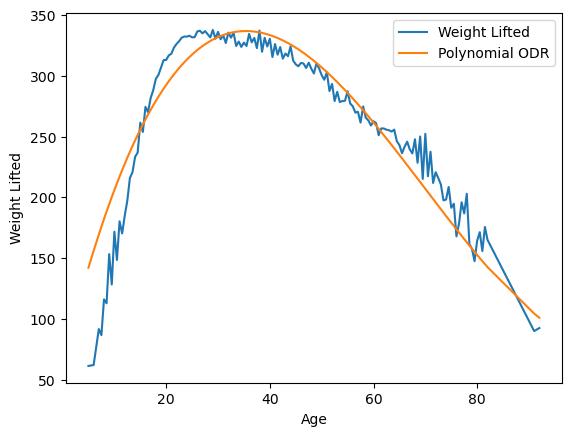

In [79]:
pord(total,'F',3)

Peak Mean Weight Lifted is at: 36.0 years old.
Recovered equation: y=-113.48x + 45.98, t=-2.83, p=5.24e-03
R_Squared: 0.9100663588550781


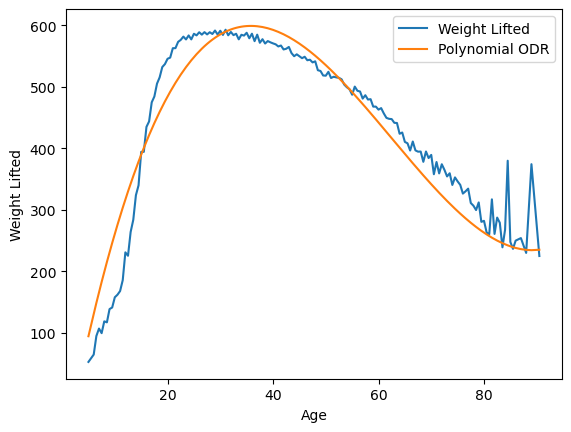

In [67]:
pord(total,'M',3)

Squat

Peak Mean Weight Lifted is at: 34.0 years old.
Recovered equation: y=16.23x + 6.95, t=3.51, p=5.87e-04
R_Squared: 0.9055558409684233


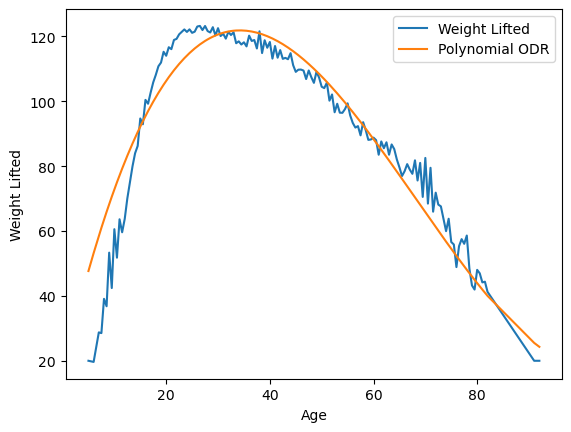

In [68]:
pord(squat,'F',3)

Peak Mean Weight Lifted is at: 35.0 years old.
Recovered equation: y=-39.68x + 16.48, t=-3.01, p=3.03e-03
R_Squared: 0.9085219651628009


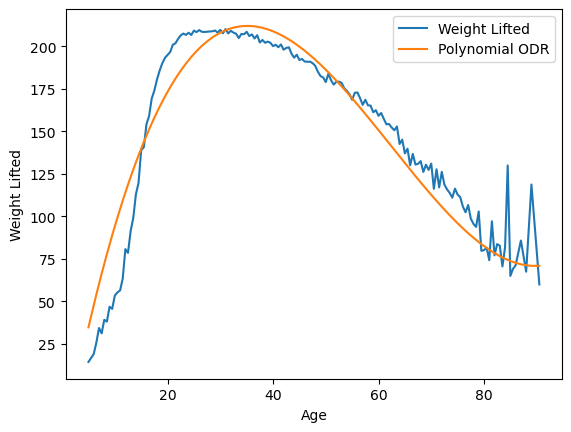

In [69]:
pord(squat,'M',3)

Bench

Peak Mean Weight Lifted is at: 36.5 years old.
Recovered equation: y=2.25x + 4.25, t=0.91, p=3.66e-01
R_Squared: 0.9306334842695387


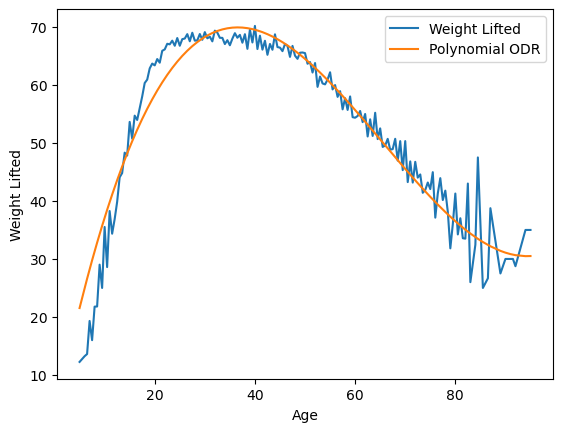

In [70]:
pord(bench,'F',3)

Peak Mean Weight Lifted is at: 39.0 years old.
Recovered equation: y=-20.10x + 9.93, t=-3.64, p=3.64e-04
R_Squared: 0.9311278961434225


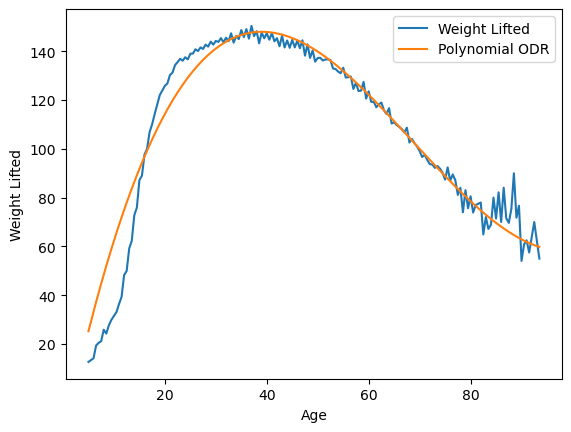

In [71]:
pord(bench,'M',3)

Deadlift

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=35.06x + 6.52, t=6.40, p=1.47e-09
R_Squared: 0.891795882796371


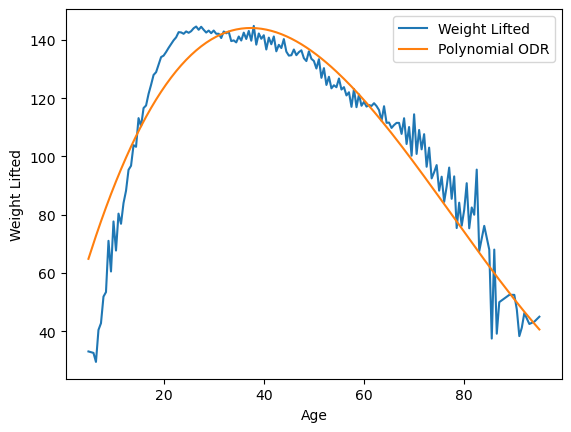

In [72]:
pord(dead,'F',3)

Peak Mean Weight Lifted is at: 36.5 years old.
Recovered equation: y=9.76x + 14.51, t=0.74, p=4.59e-01
R_Squared: 0.8641029259225366


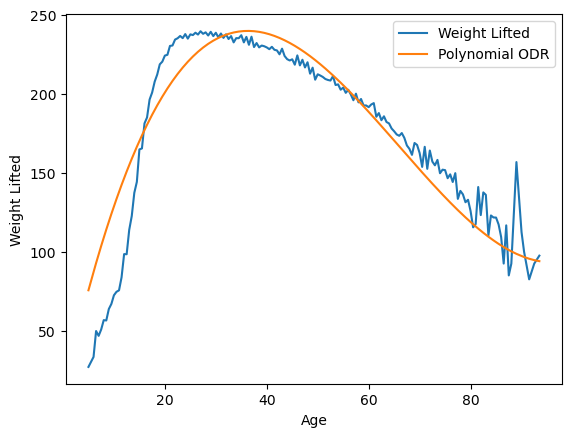

In [73]:
pord(dead,'M',3)

# Export Drug Tested Top Strength Population

Export the dataframe consisting of top 10% strength for each weight group

In [74]:
max_strength_df(total,'M').to_pickle('DT_Total_M.pkl')
max_strength_df(squat,'M').to_pickle('DT_Squat_M.pkl')
max_strength_df(bench,'M').to_pickle('DT_Bench_M.pkl')
max_strength_df(dead,'M').to_pickle('DT_Dead_M.pkl')

max_strength_df(total,'F').to_pickle('DT_Total_F.pkl')
max_strength_df(squat,'F').to_pickle('DT_Squat_F.pkl')
max_strength_df(bench,'F').to_pickle('DT_Bench_F.pkl')
max_strength_df(dead,'F').to_pickle('DT_Dead_F.pkl')